### Import Libraries


In [1]:
import pathlib
import itertools
from joblib import load

import pandas as pd
from matplotlib import pyplot as plt

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_confusion_matrix, get_SCM_model_data

### Load Datasets


In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)


### Evaluate Each Model on Each Dataset (multi class models)

#### Note: `cm` stands for confusion matrix in variable names


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


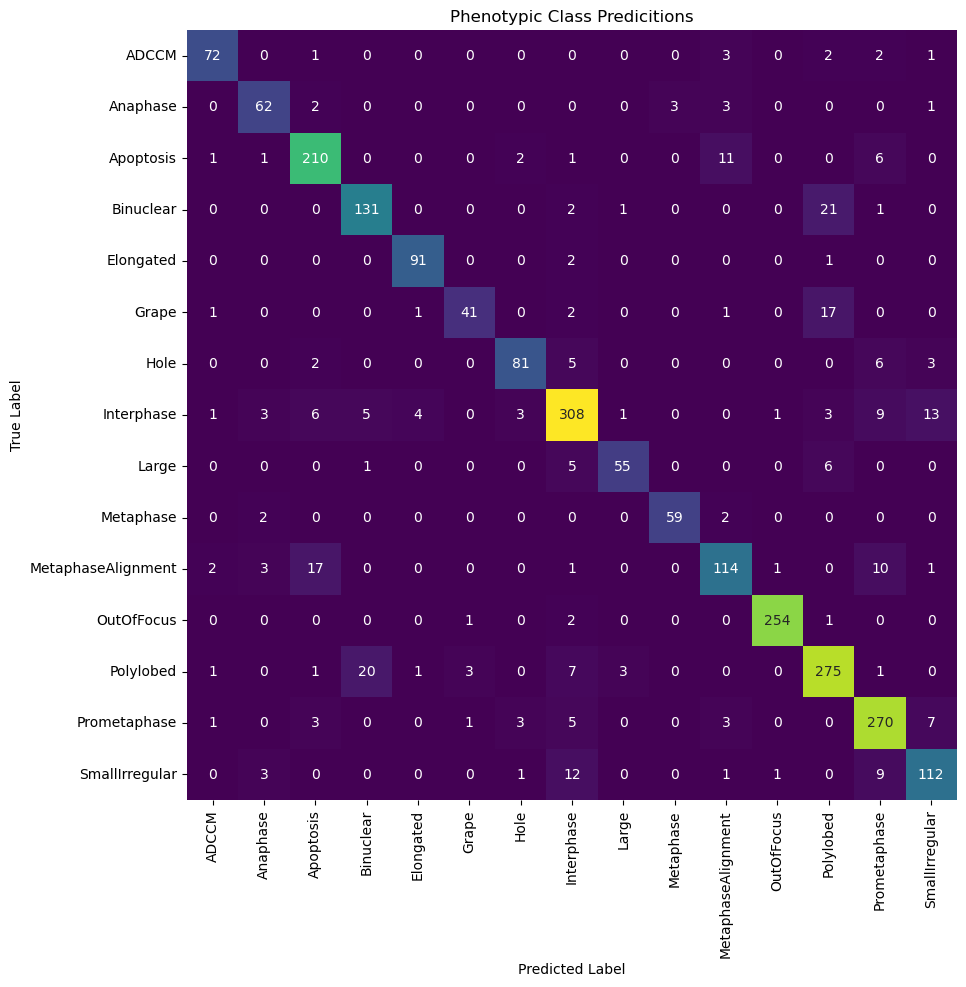

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


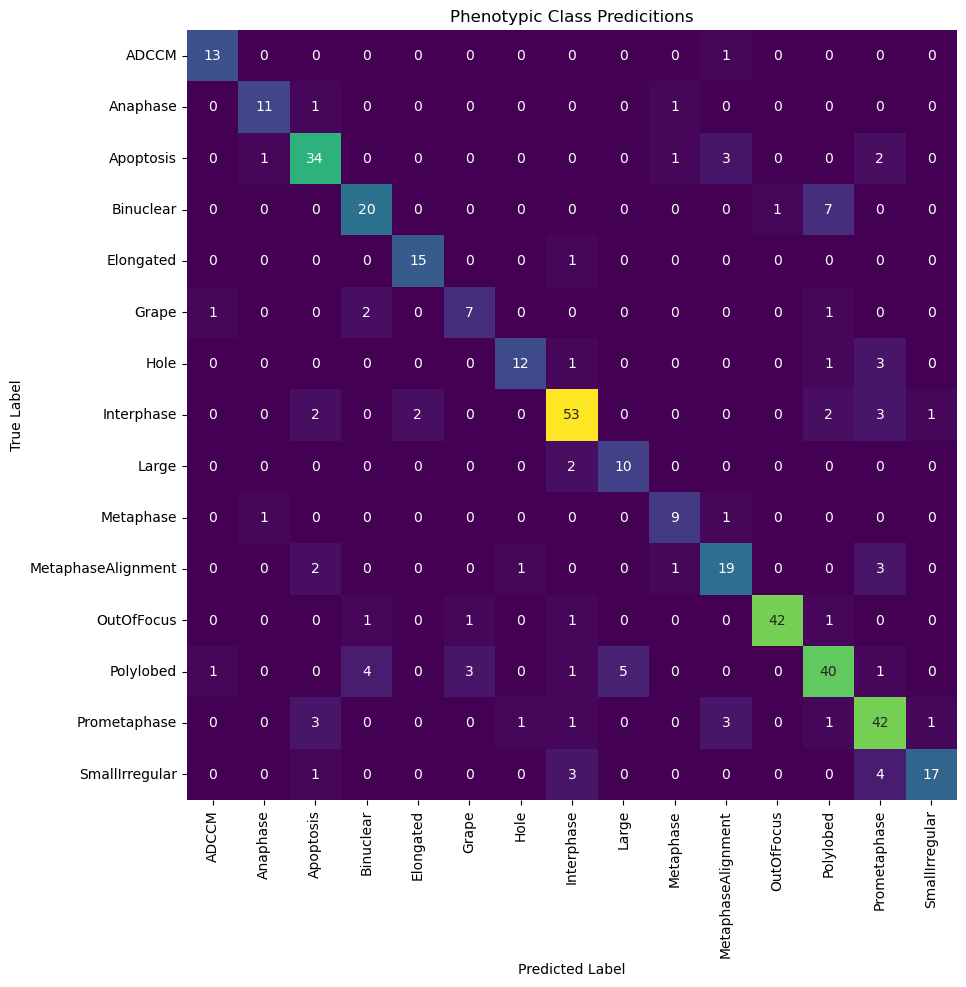

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


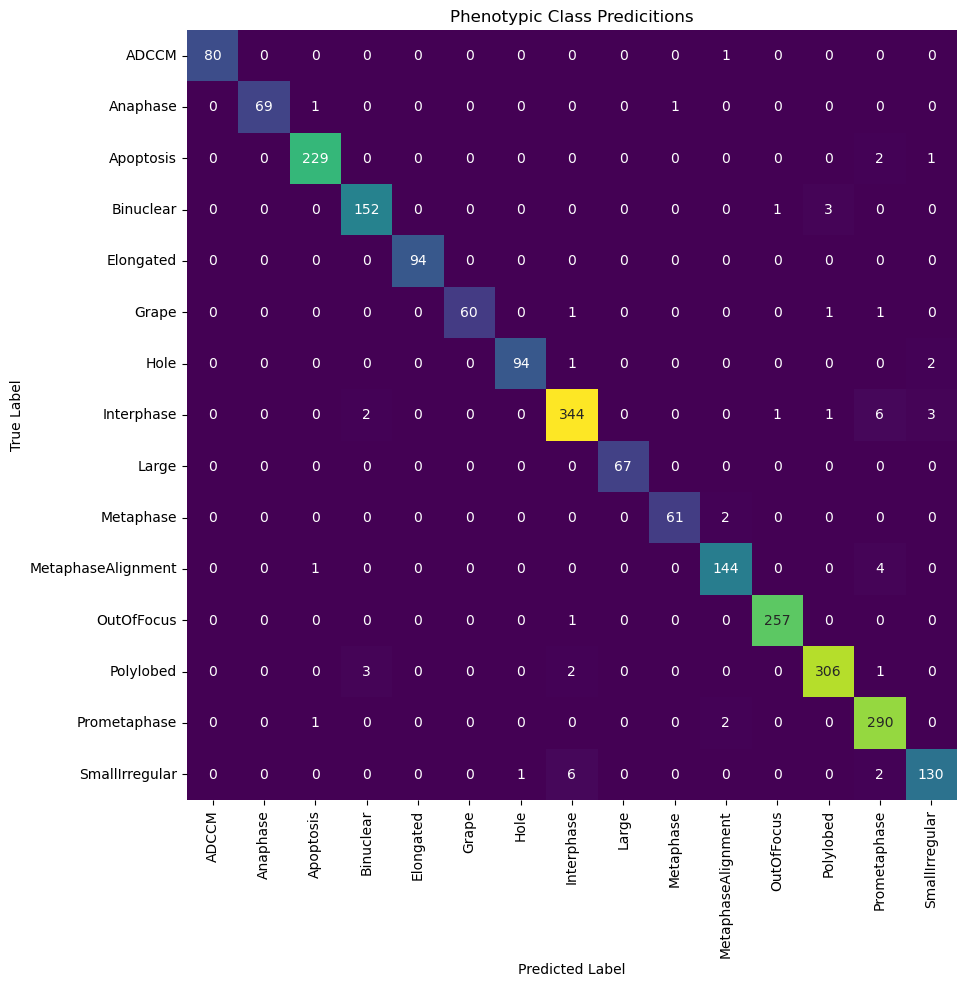

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


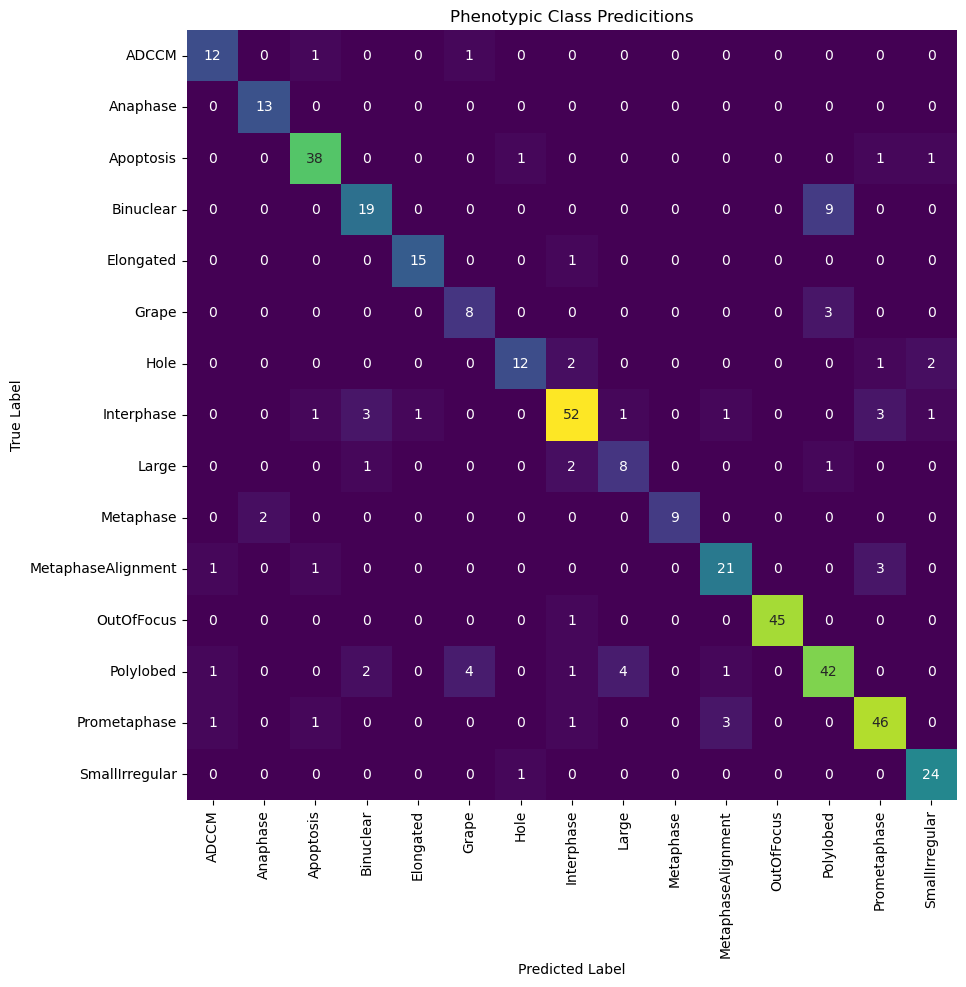

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


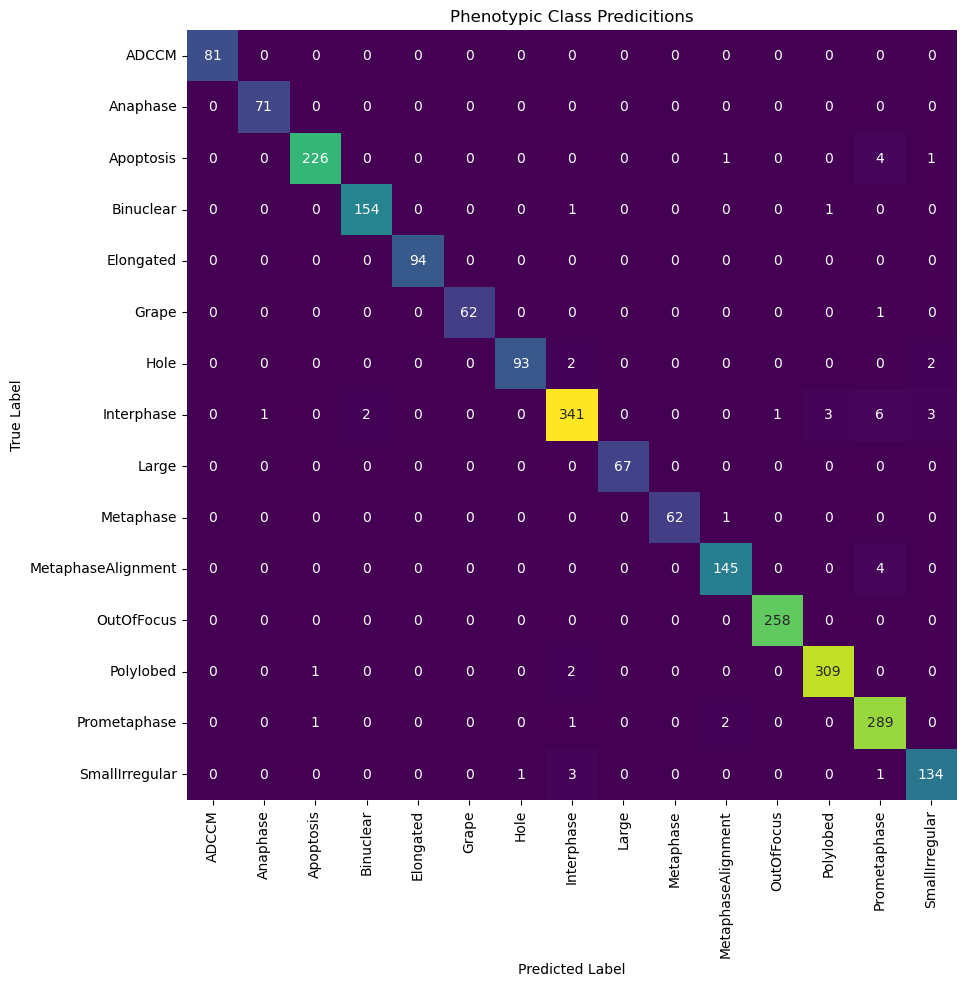

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


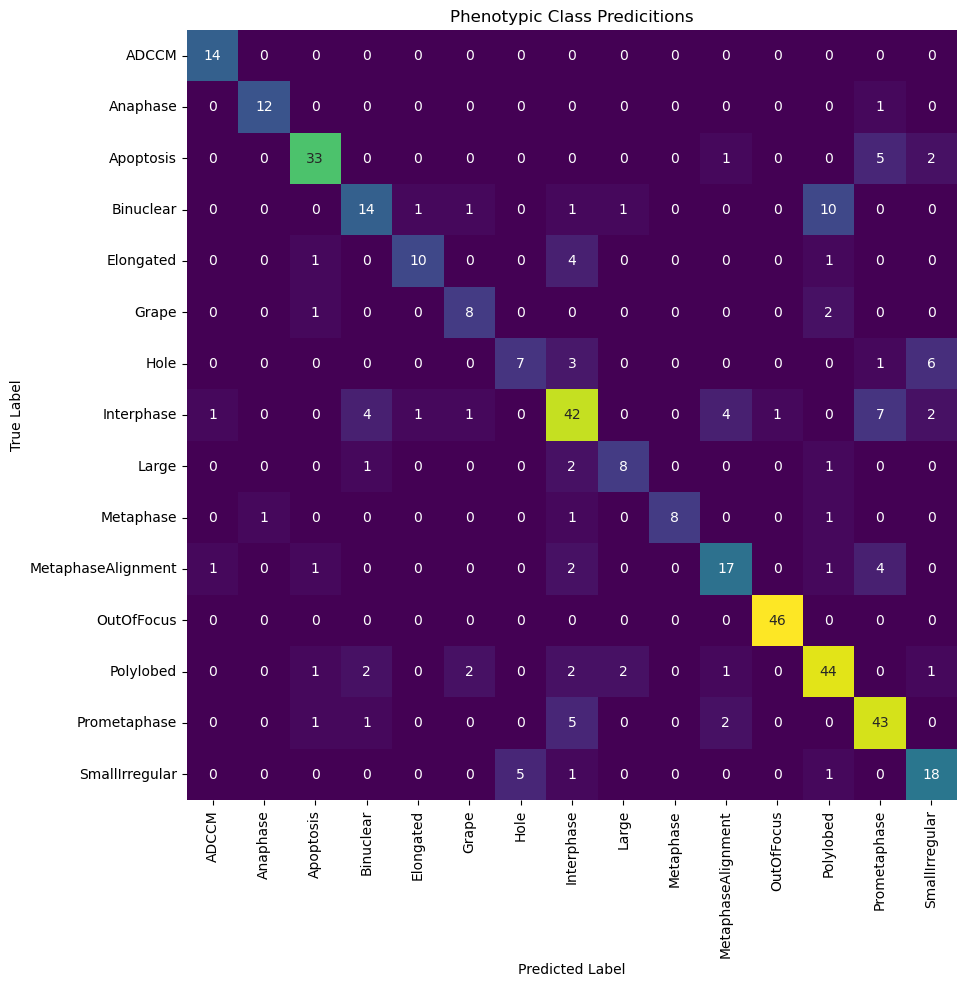

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


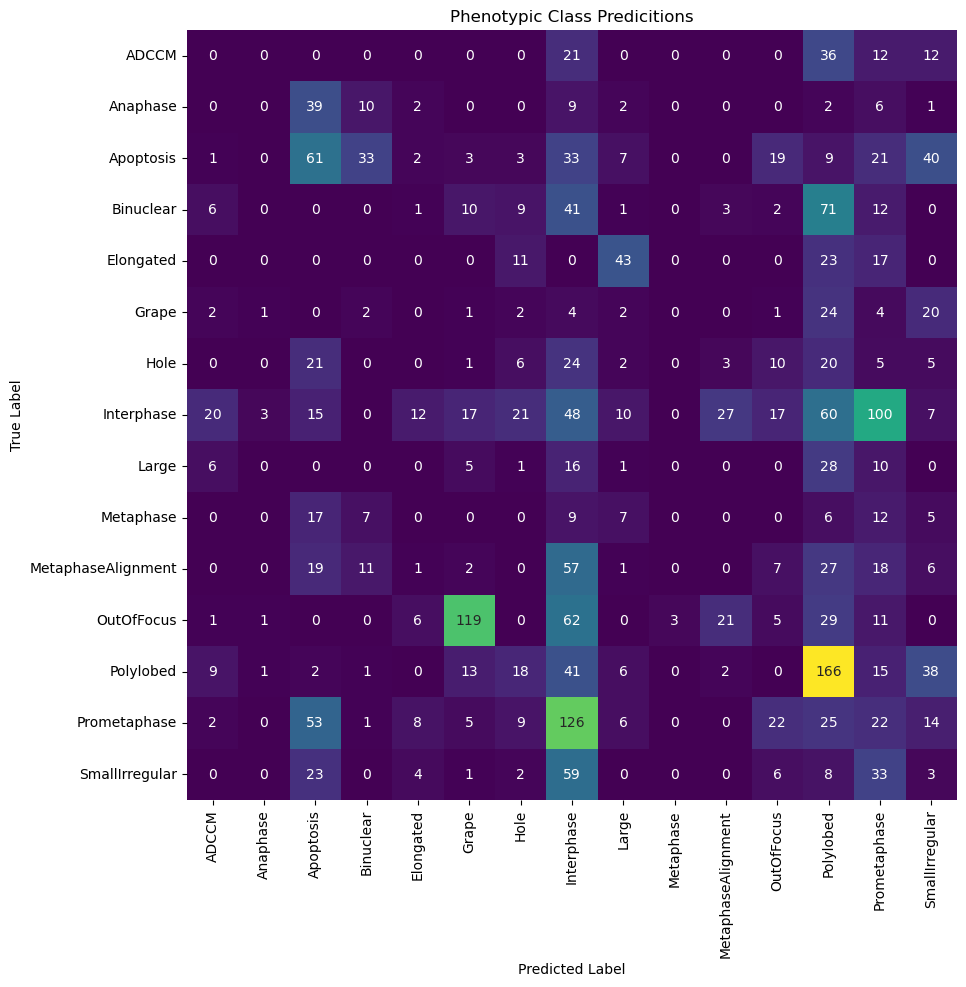

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


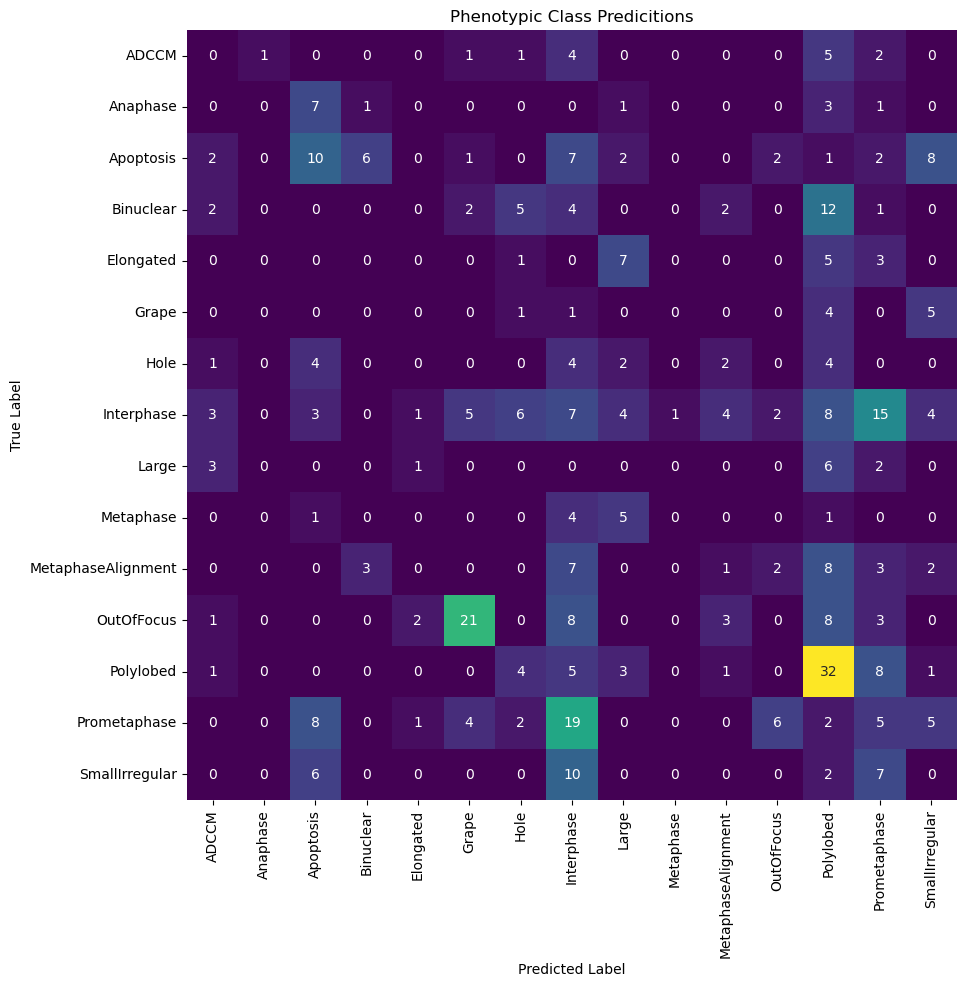

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


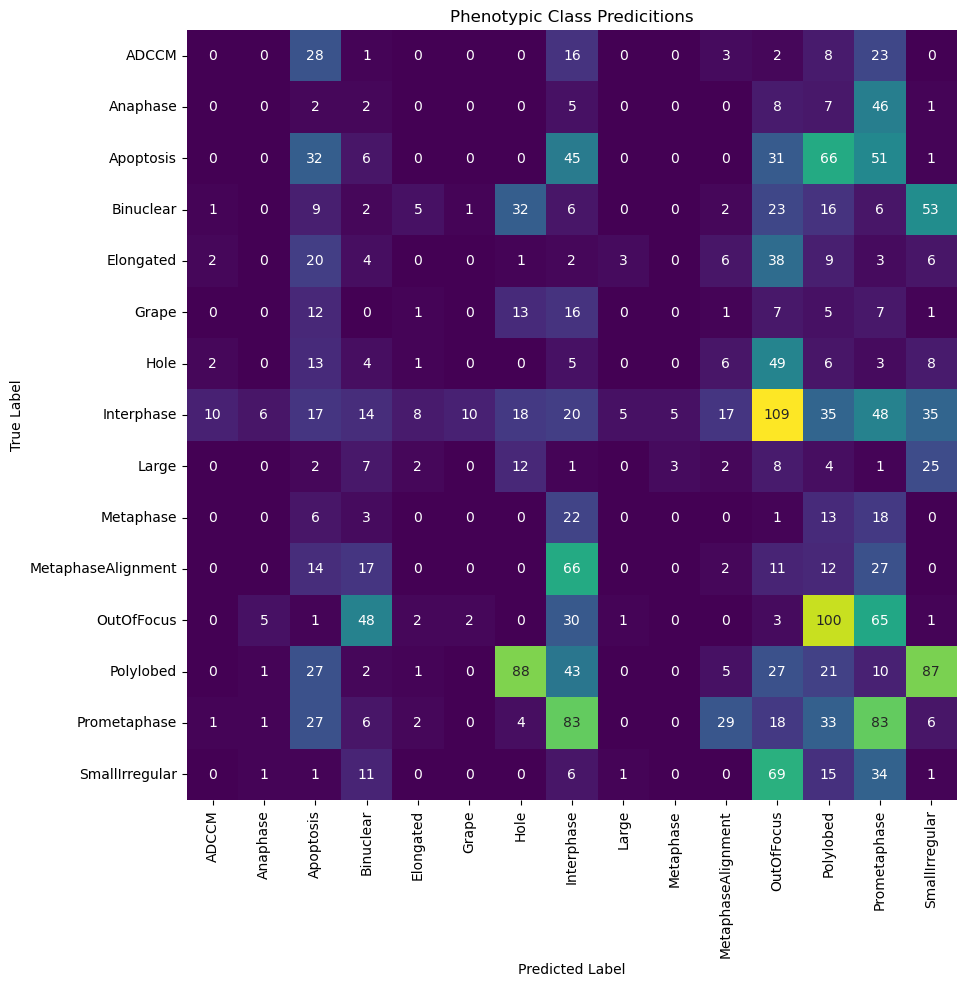

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


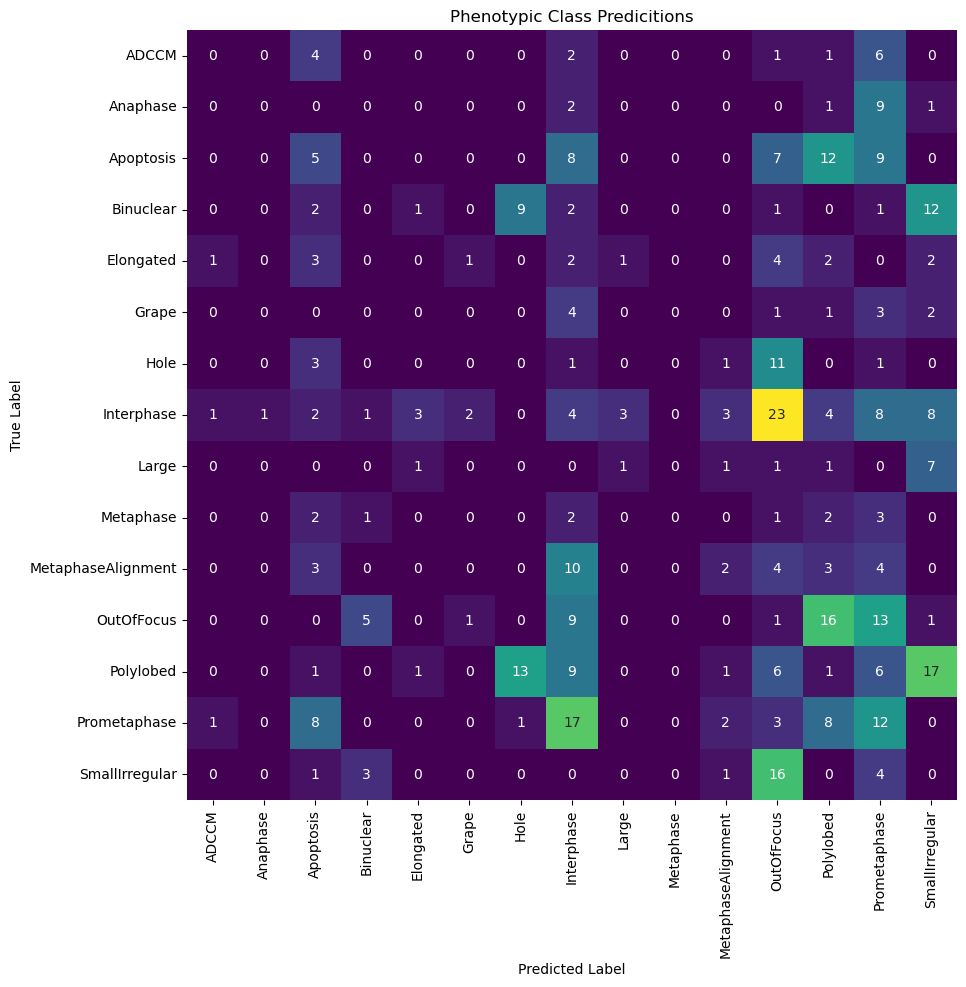

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


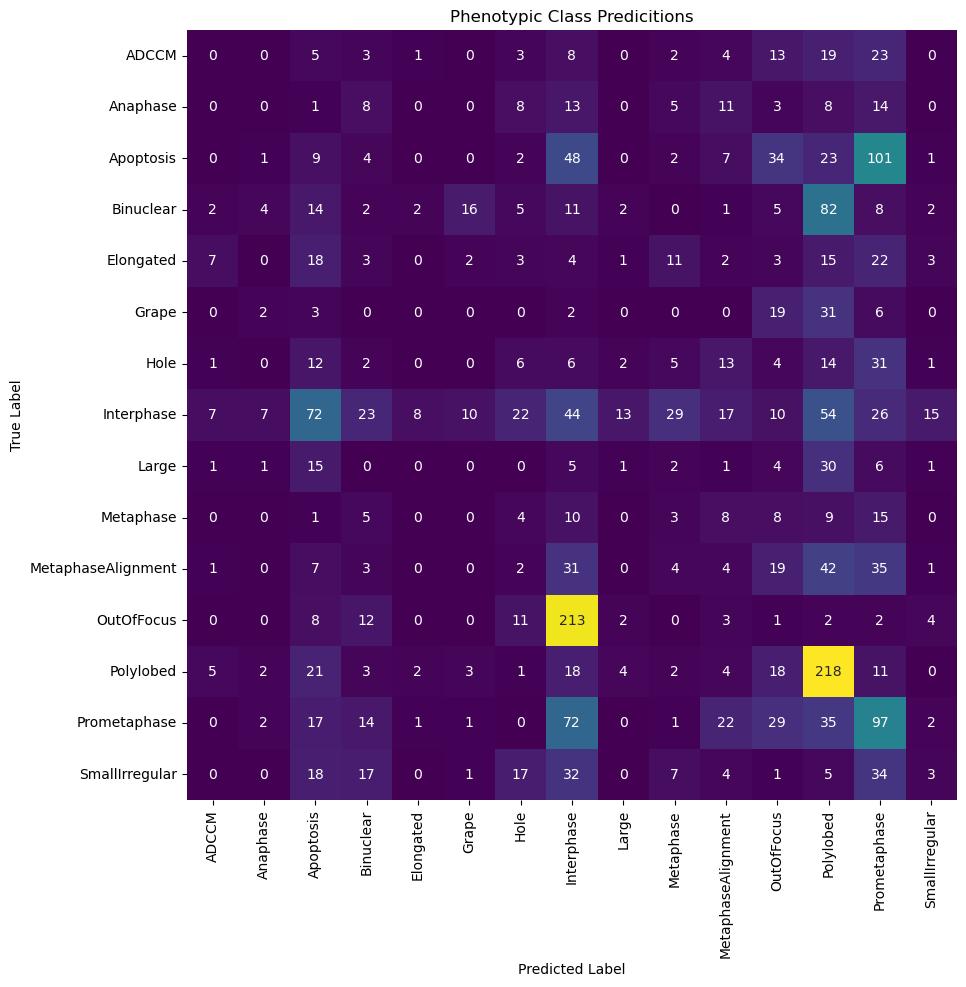

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


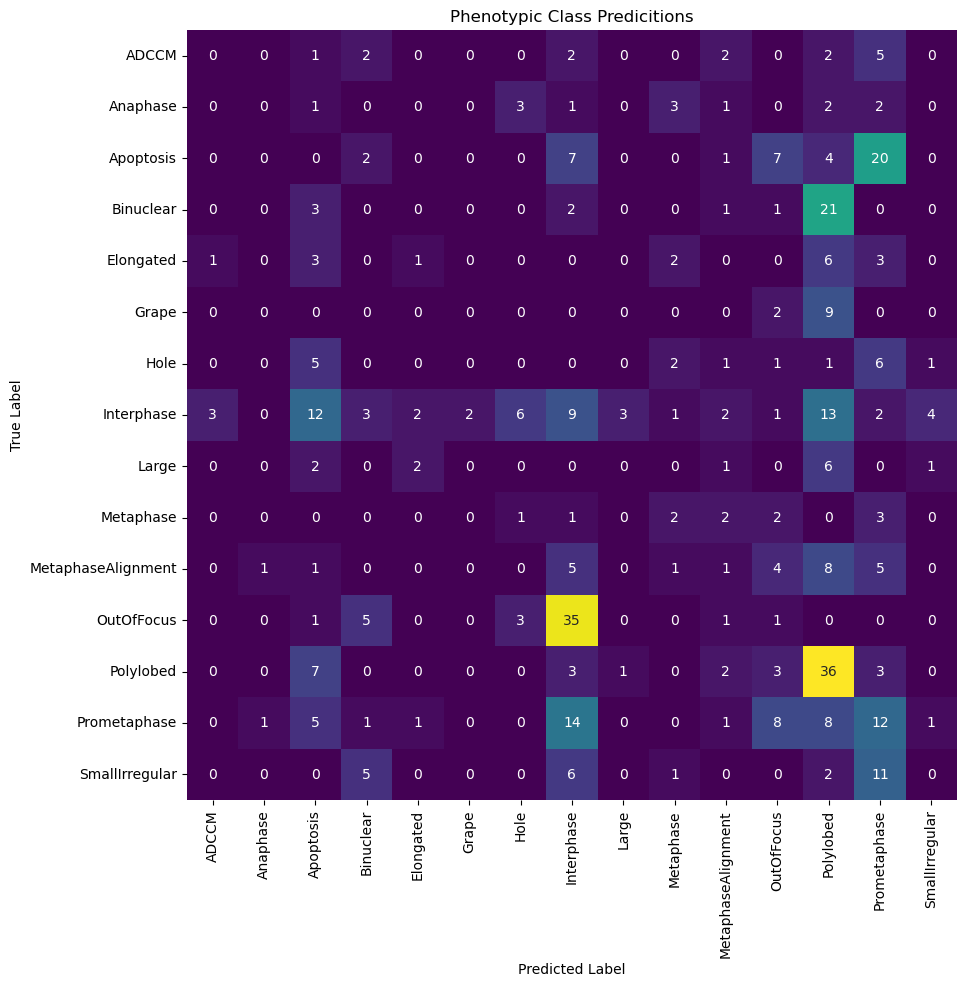

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_cm_data = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # set figure size before creating confusion matrix
        plt.figure(figsize=(10, 10))
        # plot confusion matrix for chosen model evaluated on chosen dataset
        cm_data, ax = model_confusion_matrix(model, data, feature_type)
        ax.set_title("Phenotypic Class Predicitions")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        plt.show()

        # add confusion matrix data to compiled dataframe in tidy format
        # use stack to restructure dataframe into tidy long format
        cm_data = cm_data.stack()
        # reset index must be used to make indexes at level 0 and 1 into individual columns
        # these columns correspond to true label and predicted label, and are set as indexes after using stack()
        cm_data = pd.DataFrame(cm_data).reset_index(level=[0, 1])
        cm_data.columns = ["True_Label", "Predicted_Label", "Count"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        cm_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        cm_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        cm_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_cm_data.append(cm_data)


### Save PR curve data from each evaluation (multi class models)


In [4]:
# compile list of tidy data into one dataframe
compiled_cm_data = pd.concat(compiled_cm_data).reset_index(drop=True)

# specify results directory
cm_data_dir = pathlib.Path("evaluations/confusion_matrices/")
cm_data_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_cm_data_save_path = pathlib.Path(f"{cm_data_dir}/compiled_cm_data.tsv")

# save data as tsv
compiled_cm_data.to_csv(compiled_cm_data_save_path, sep="\t")

# preview tidy data
compiled_cm_data


True_Label     Predicted_Label  Count data_split  shuffled  \
0              ADCCM               ADCCM     72      train     False   
1              ADCCM            Anaphase      0      train     False   
2              ADCCM           Apoptosis      1      train     False   
3              ADCCM           Binuclear      0      train     False   
4              ADCCM           Elongated      0      train     False   
...              ...                 ...    ...        ...       ...   
2695  SmallIrregular  MetaphaseAlignment      0       test      True   
2696  SmallIrregular          OutOfFocus      0       test      True   
2697  SmallIrregular           Polylobed      2       test      True   
2698  SmallIrregular        Prometaphase     11       test      True   
2699  SmallIrregular      SmallIrregular      0       test      True   

     feature_type  
0              CP  
1              CP  
2              CP  
3              CP  
4              CP  
...           ...  
2695           DP  
2696           DP  
2697           DP  
2698           DP  
2699           DP  

[2700 rows x 6 columns]

### Evaluate Each Model on Each Dataset (single class models)


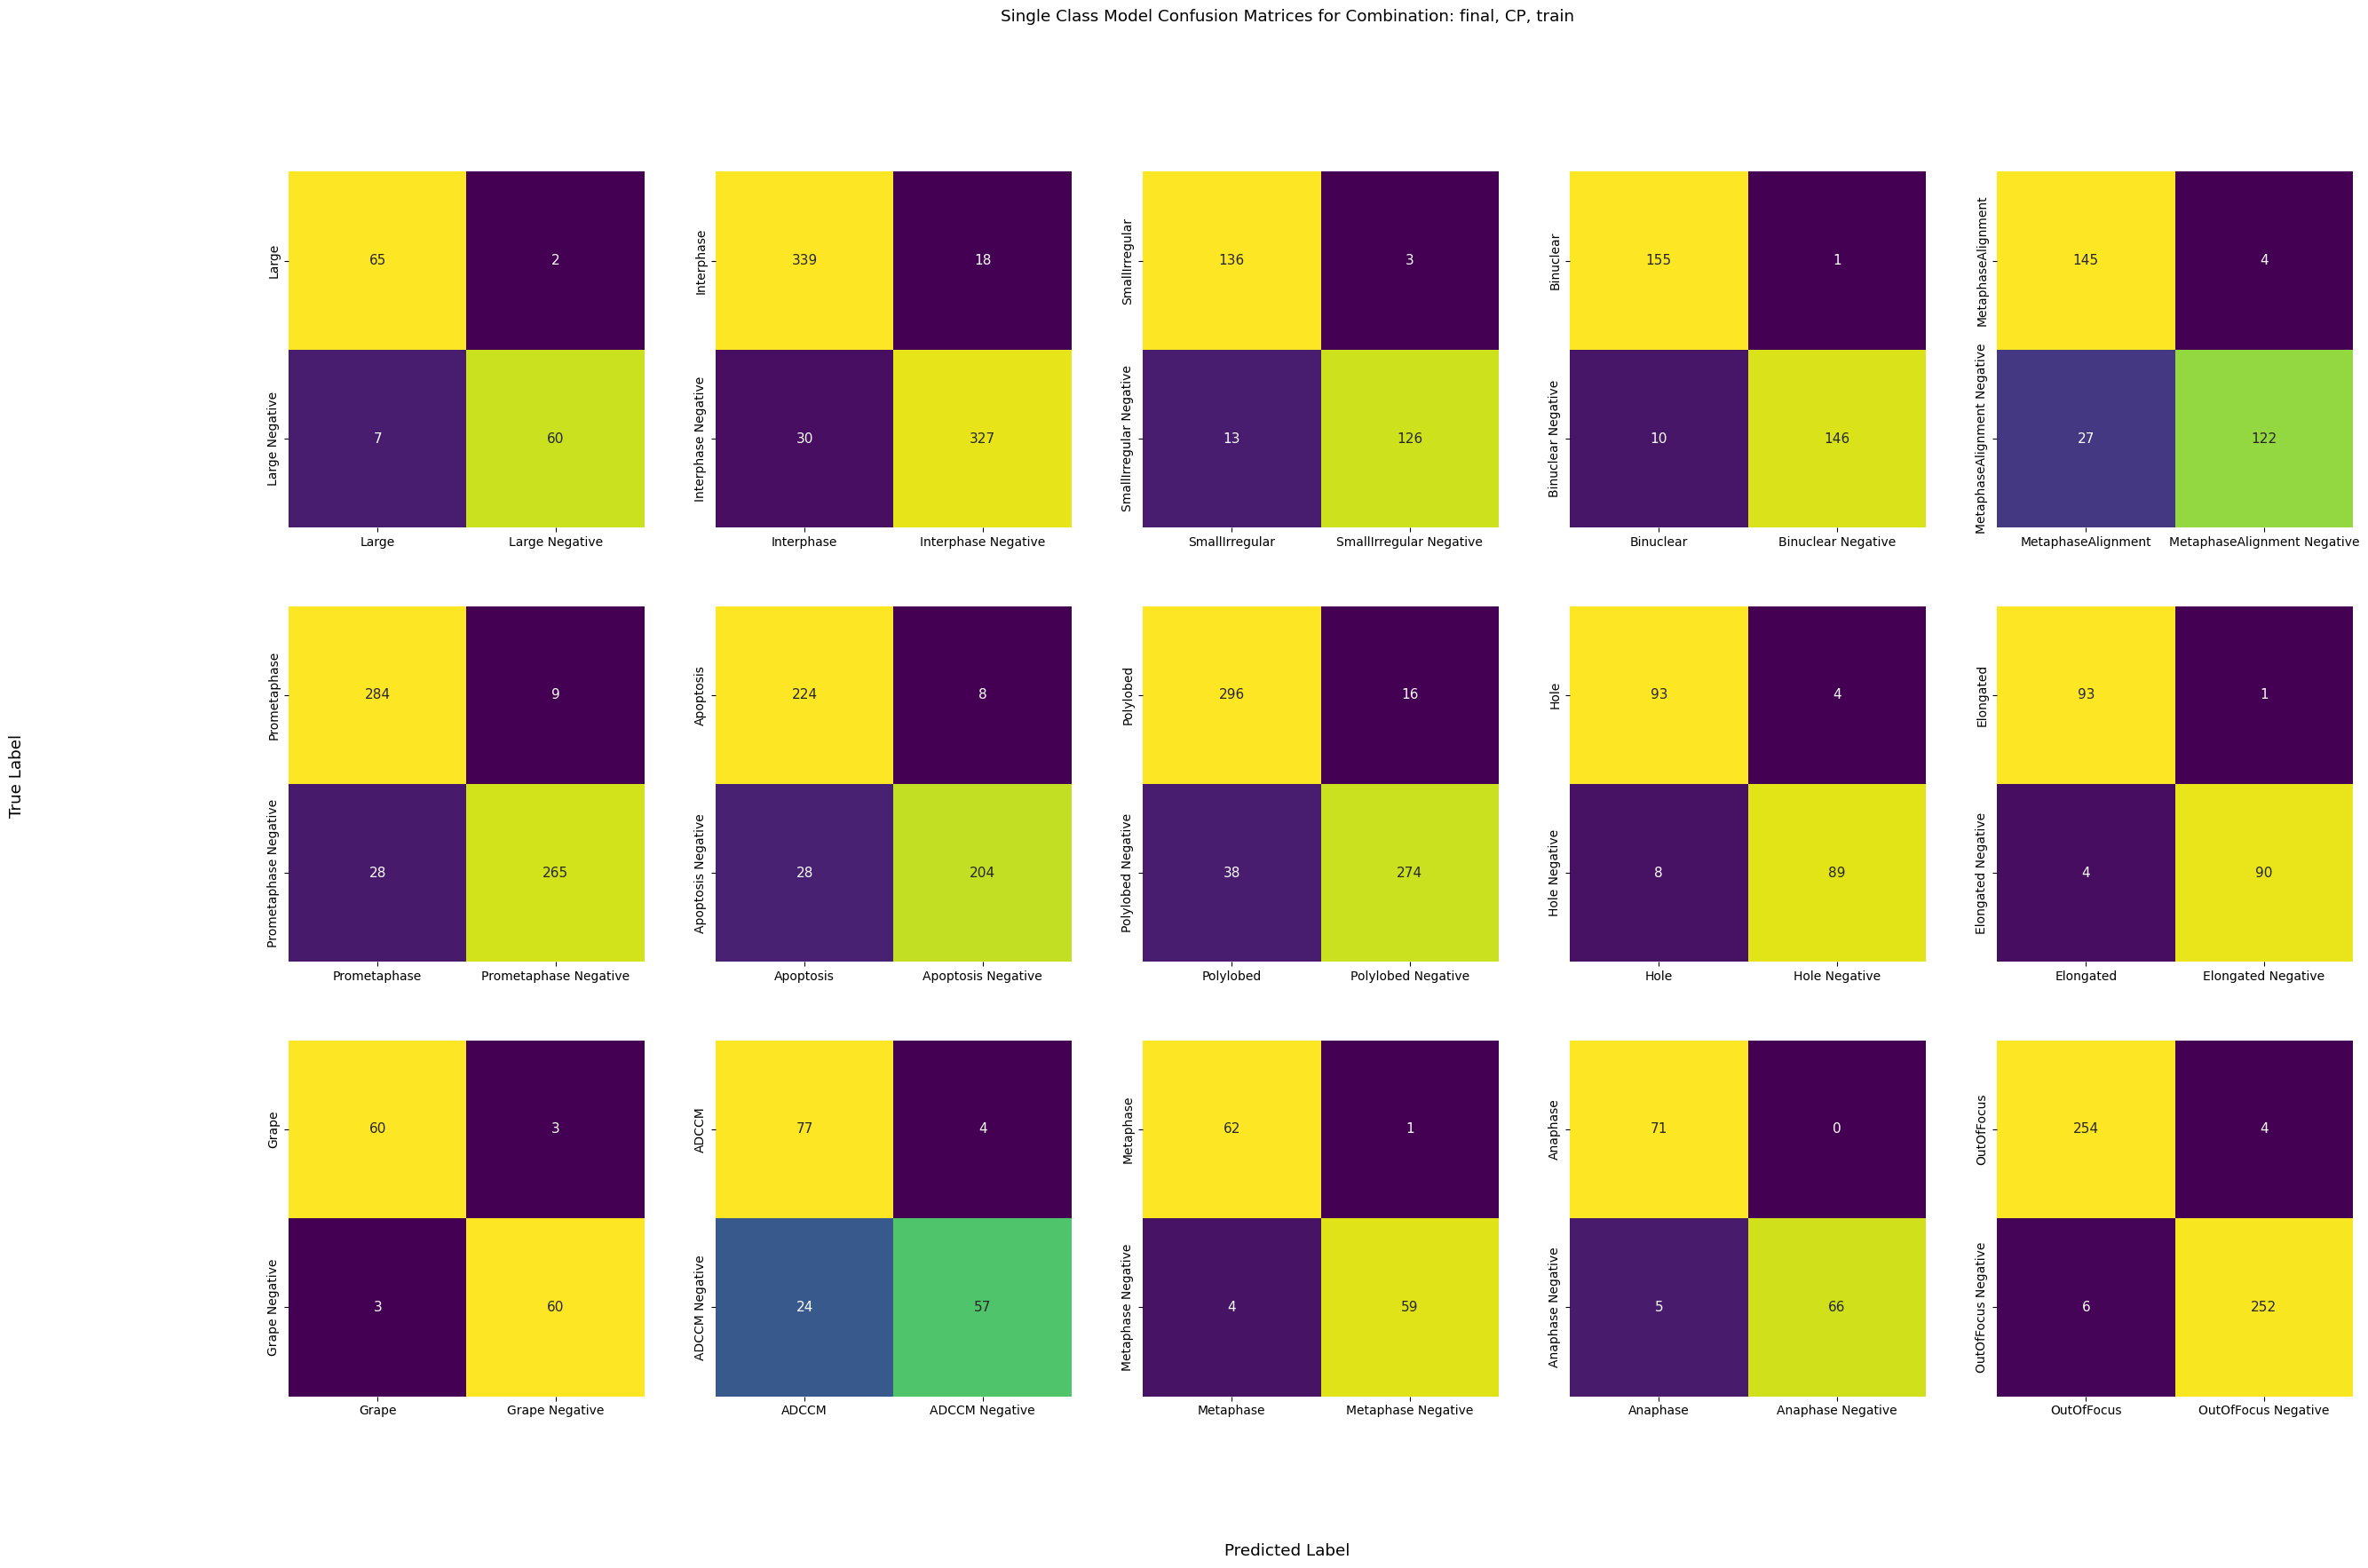

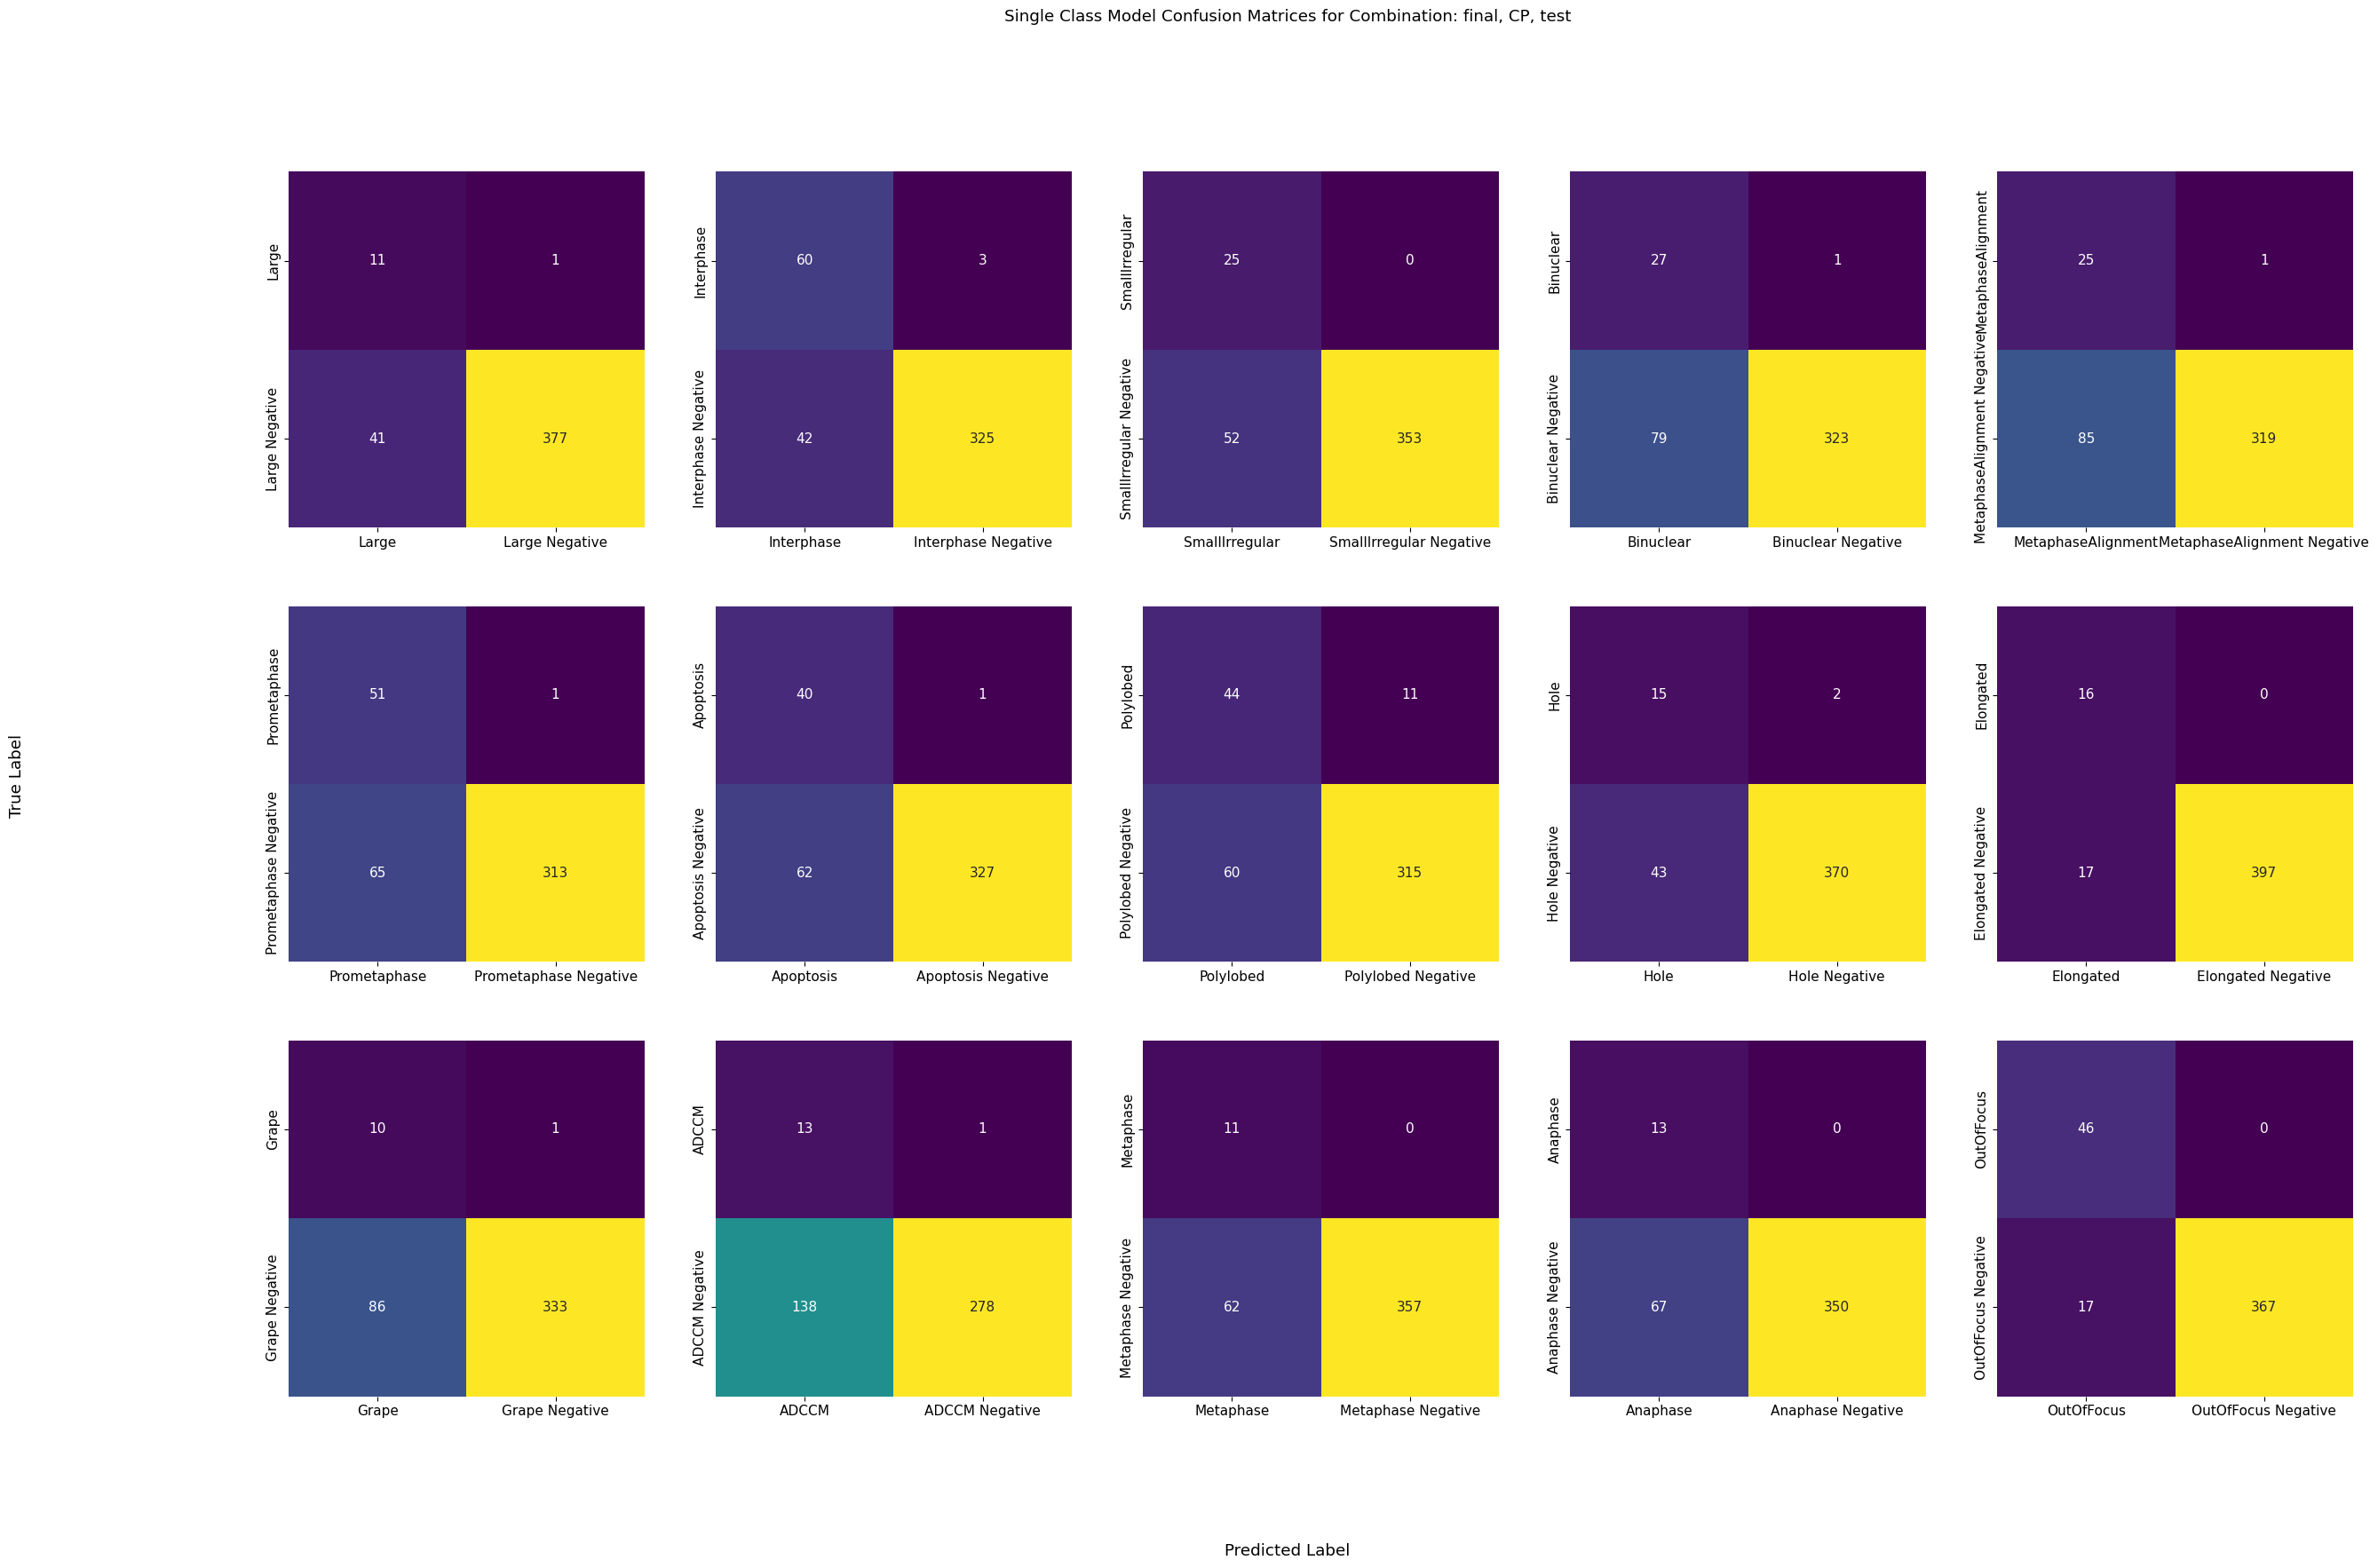

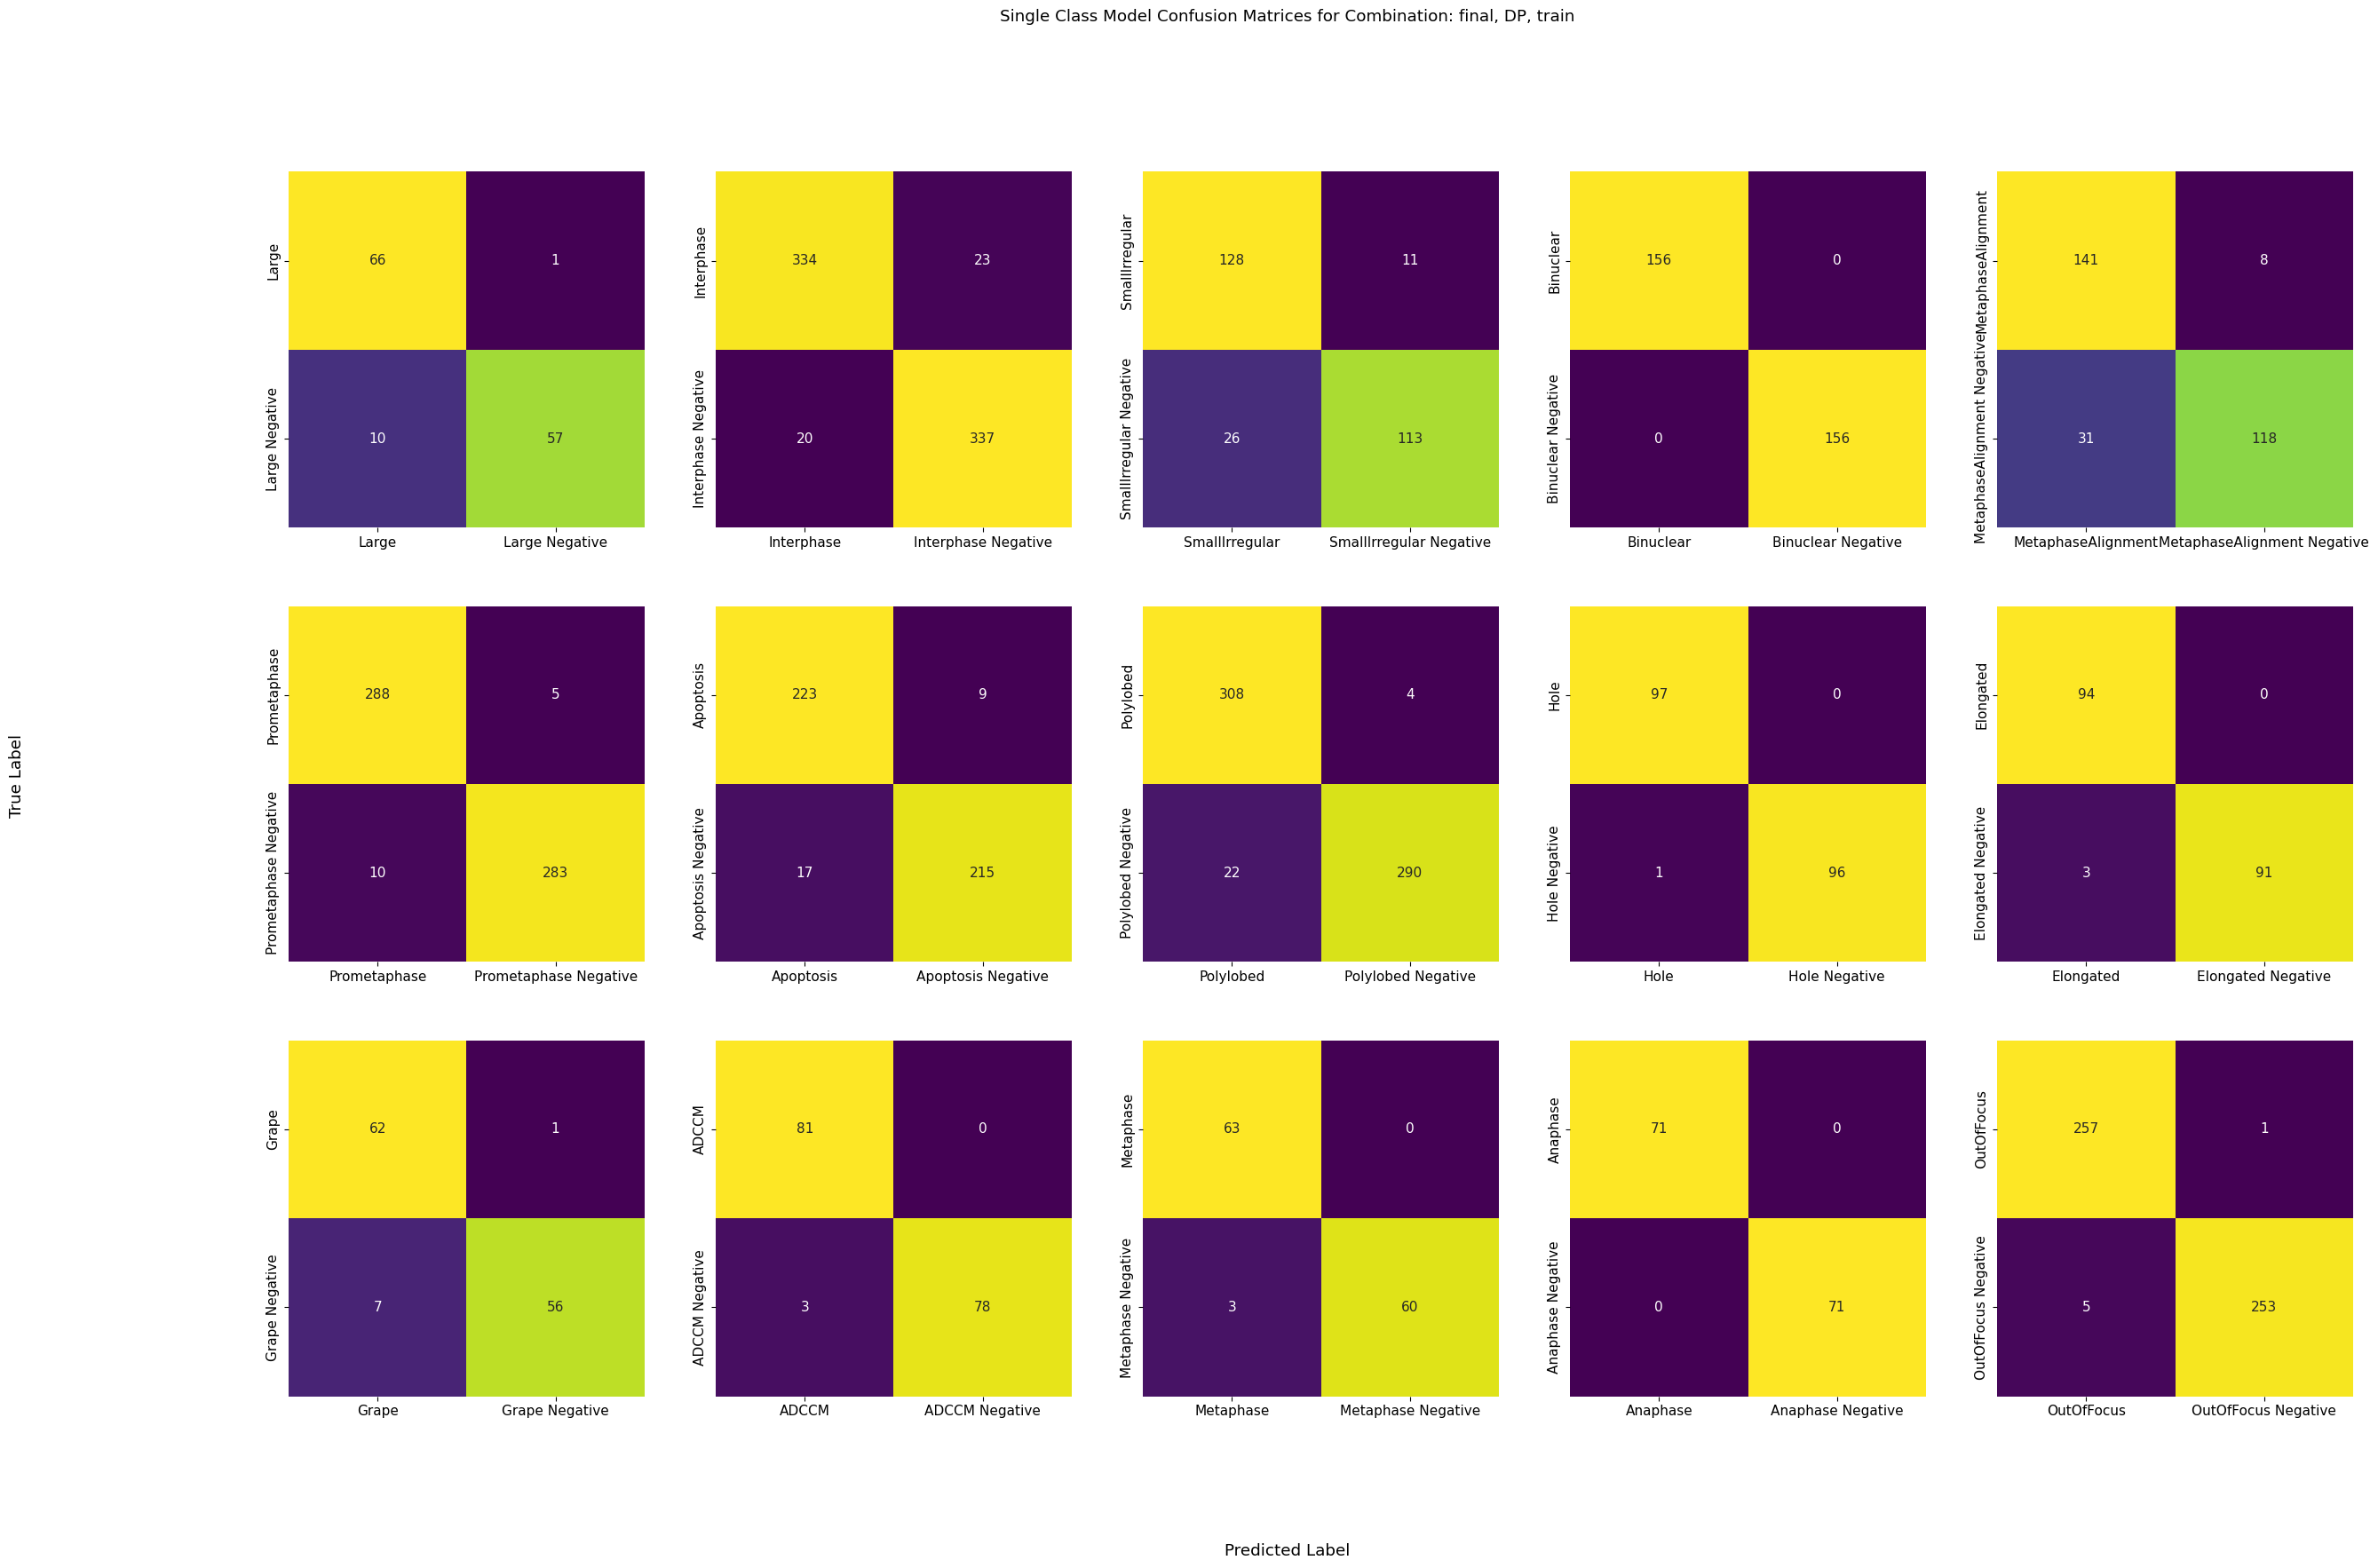

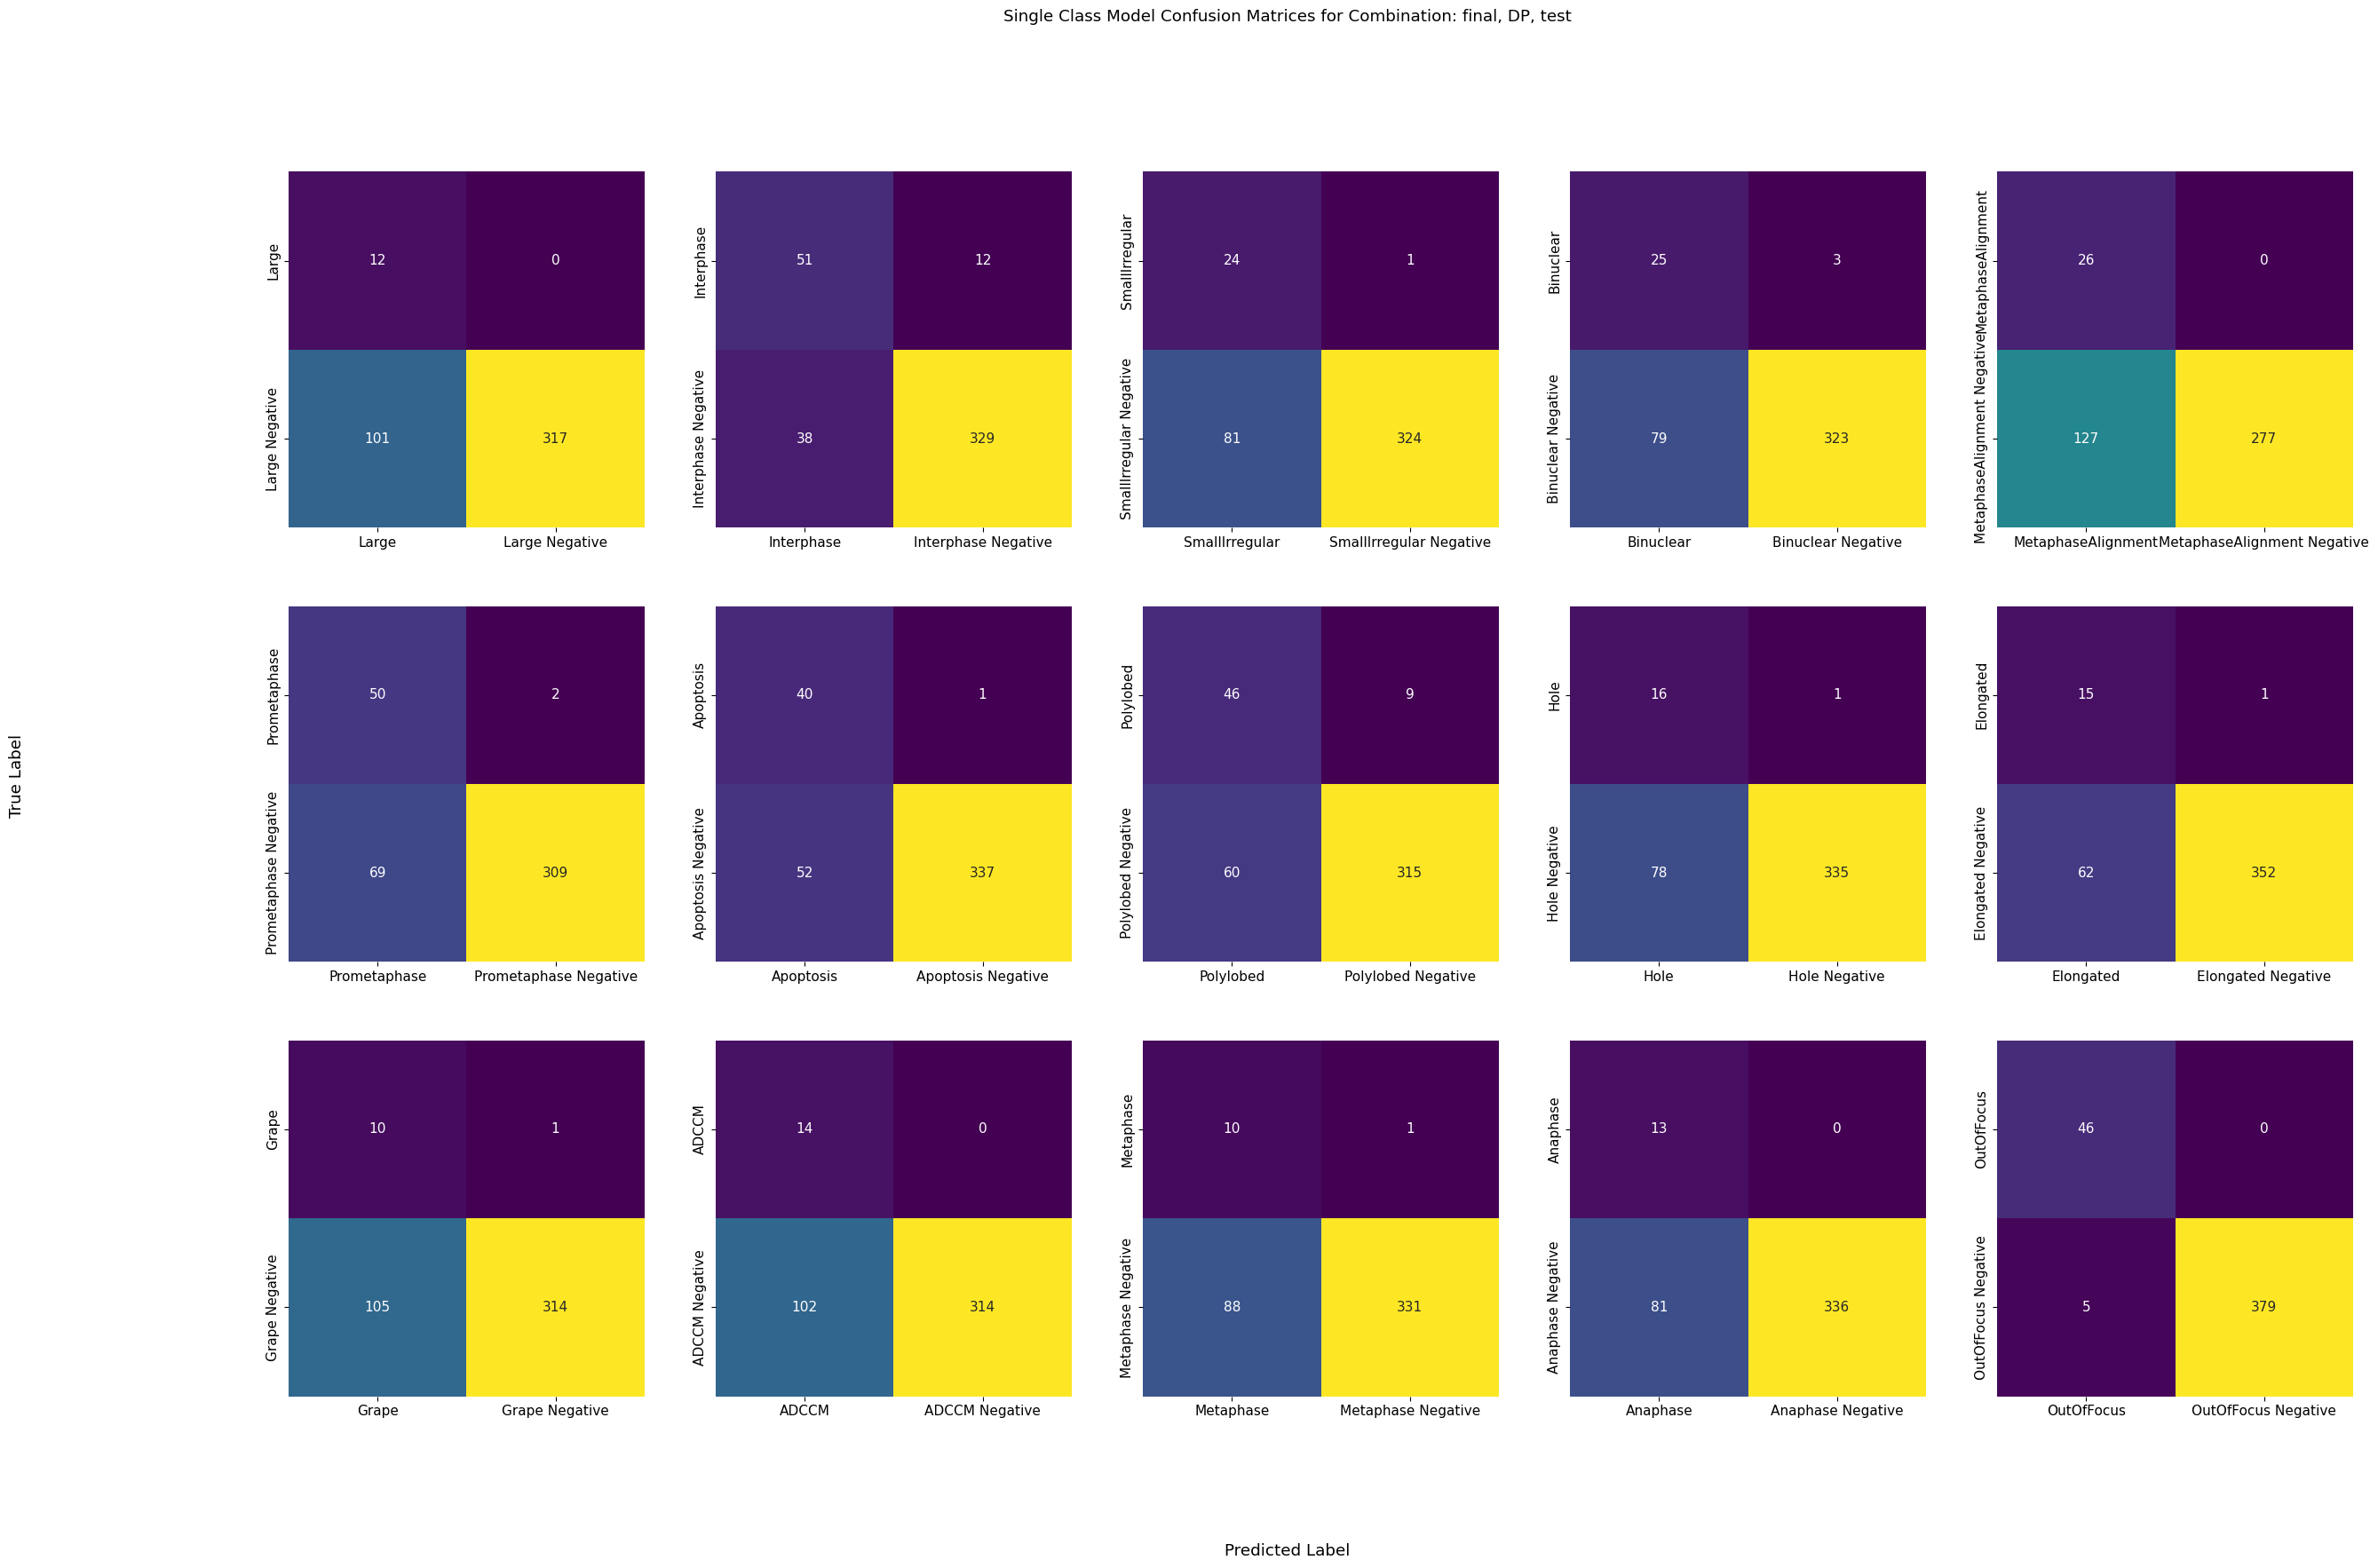

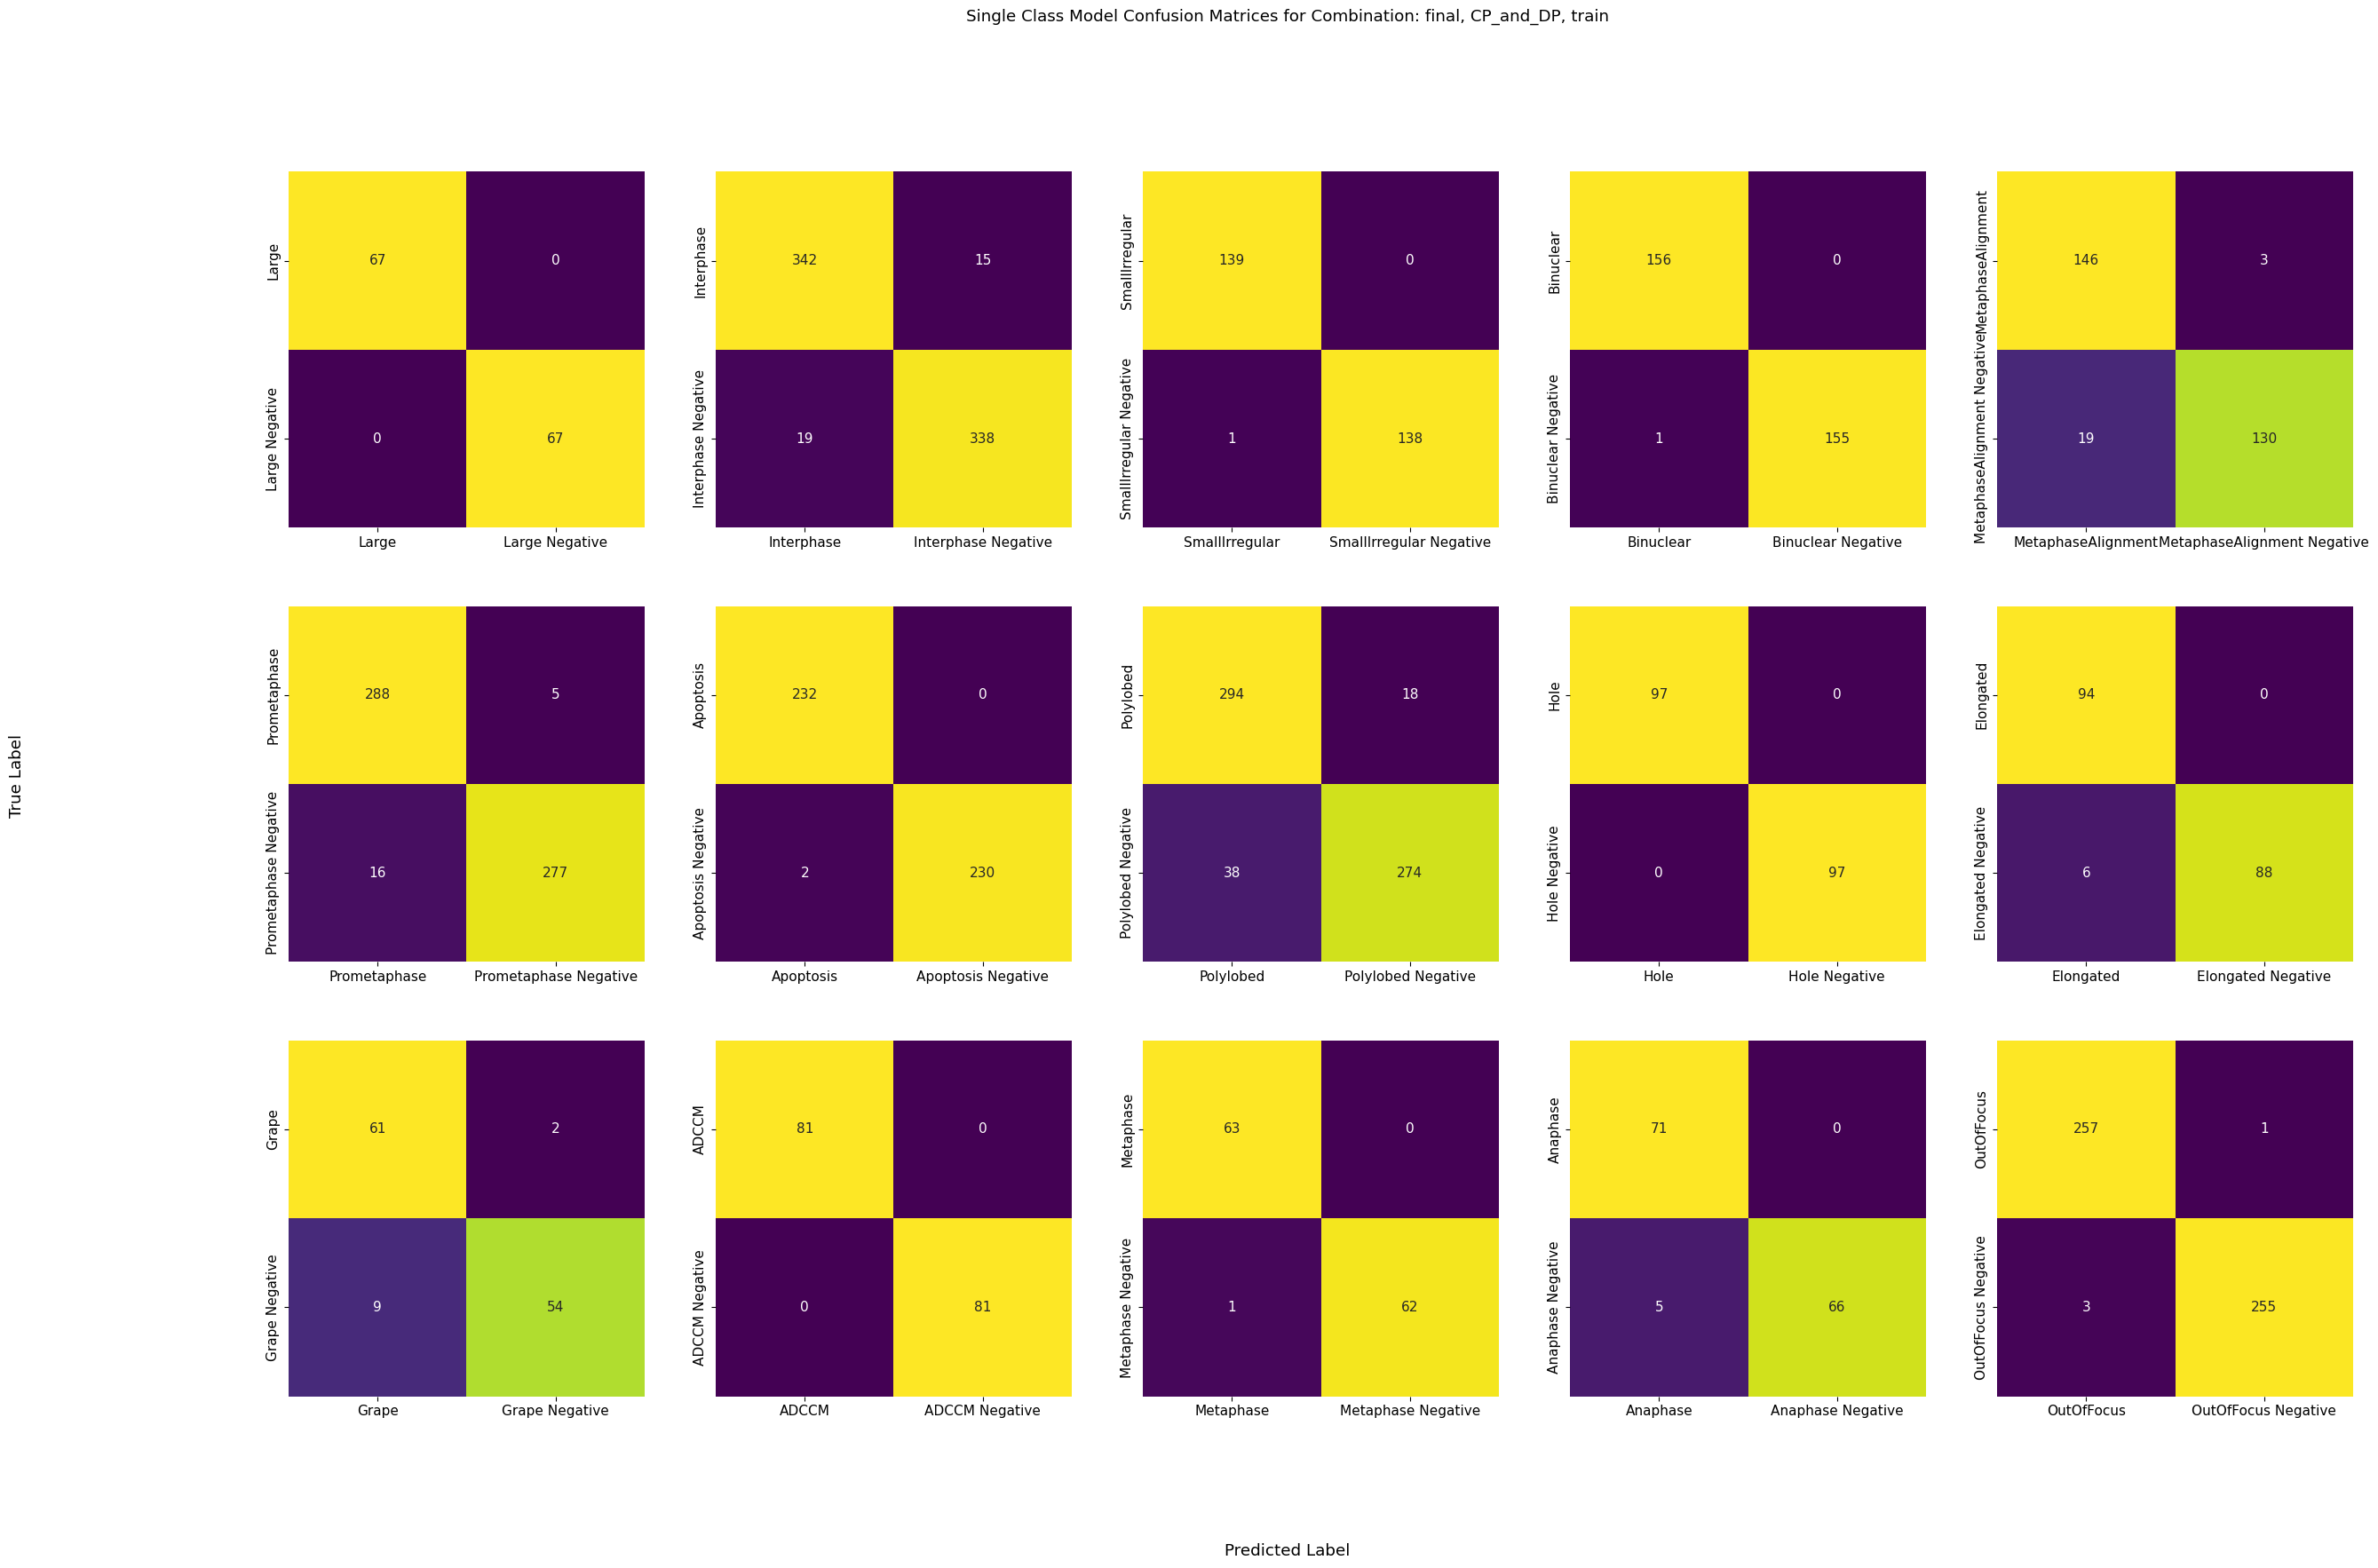

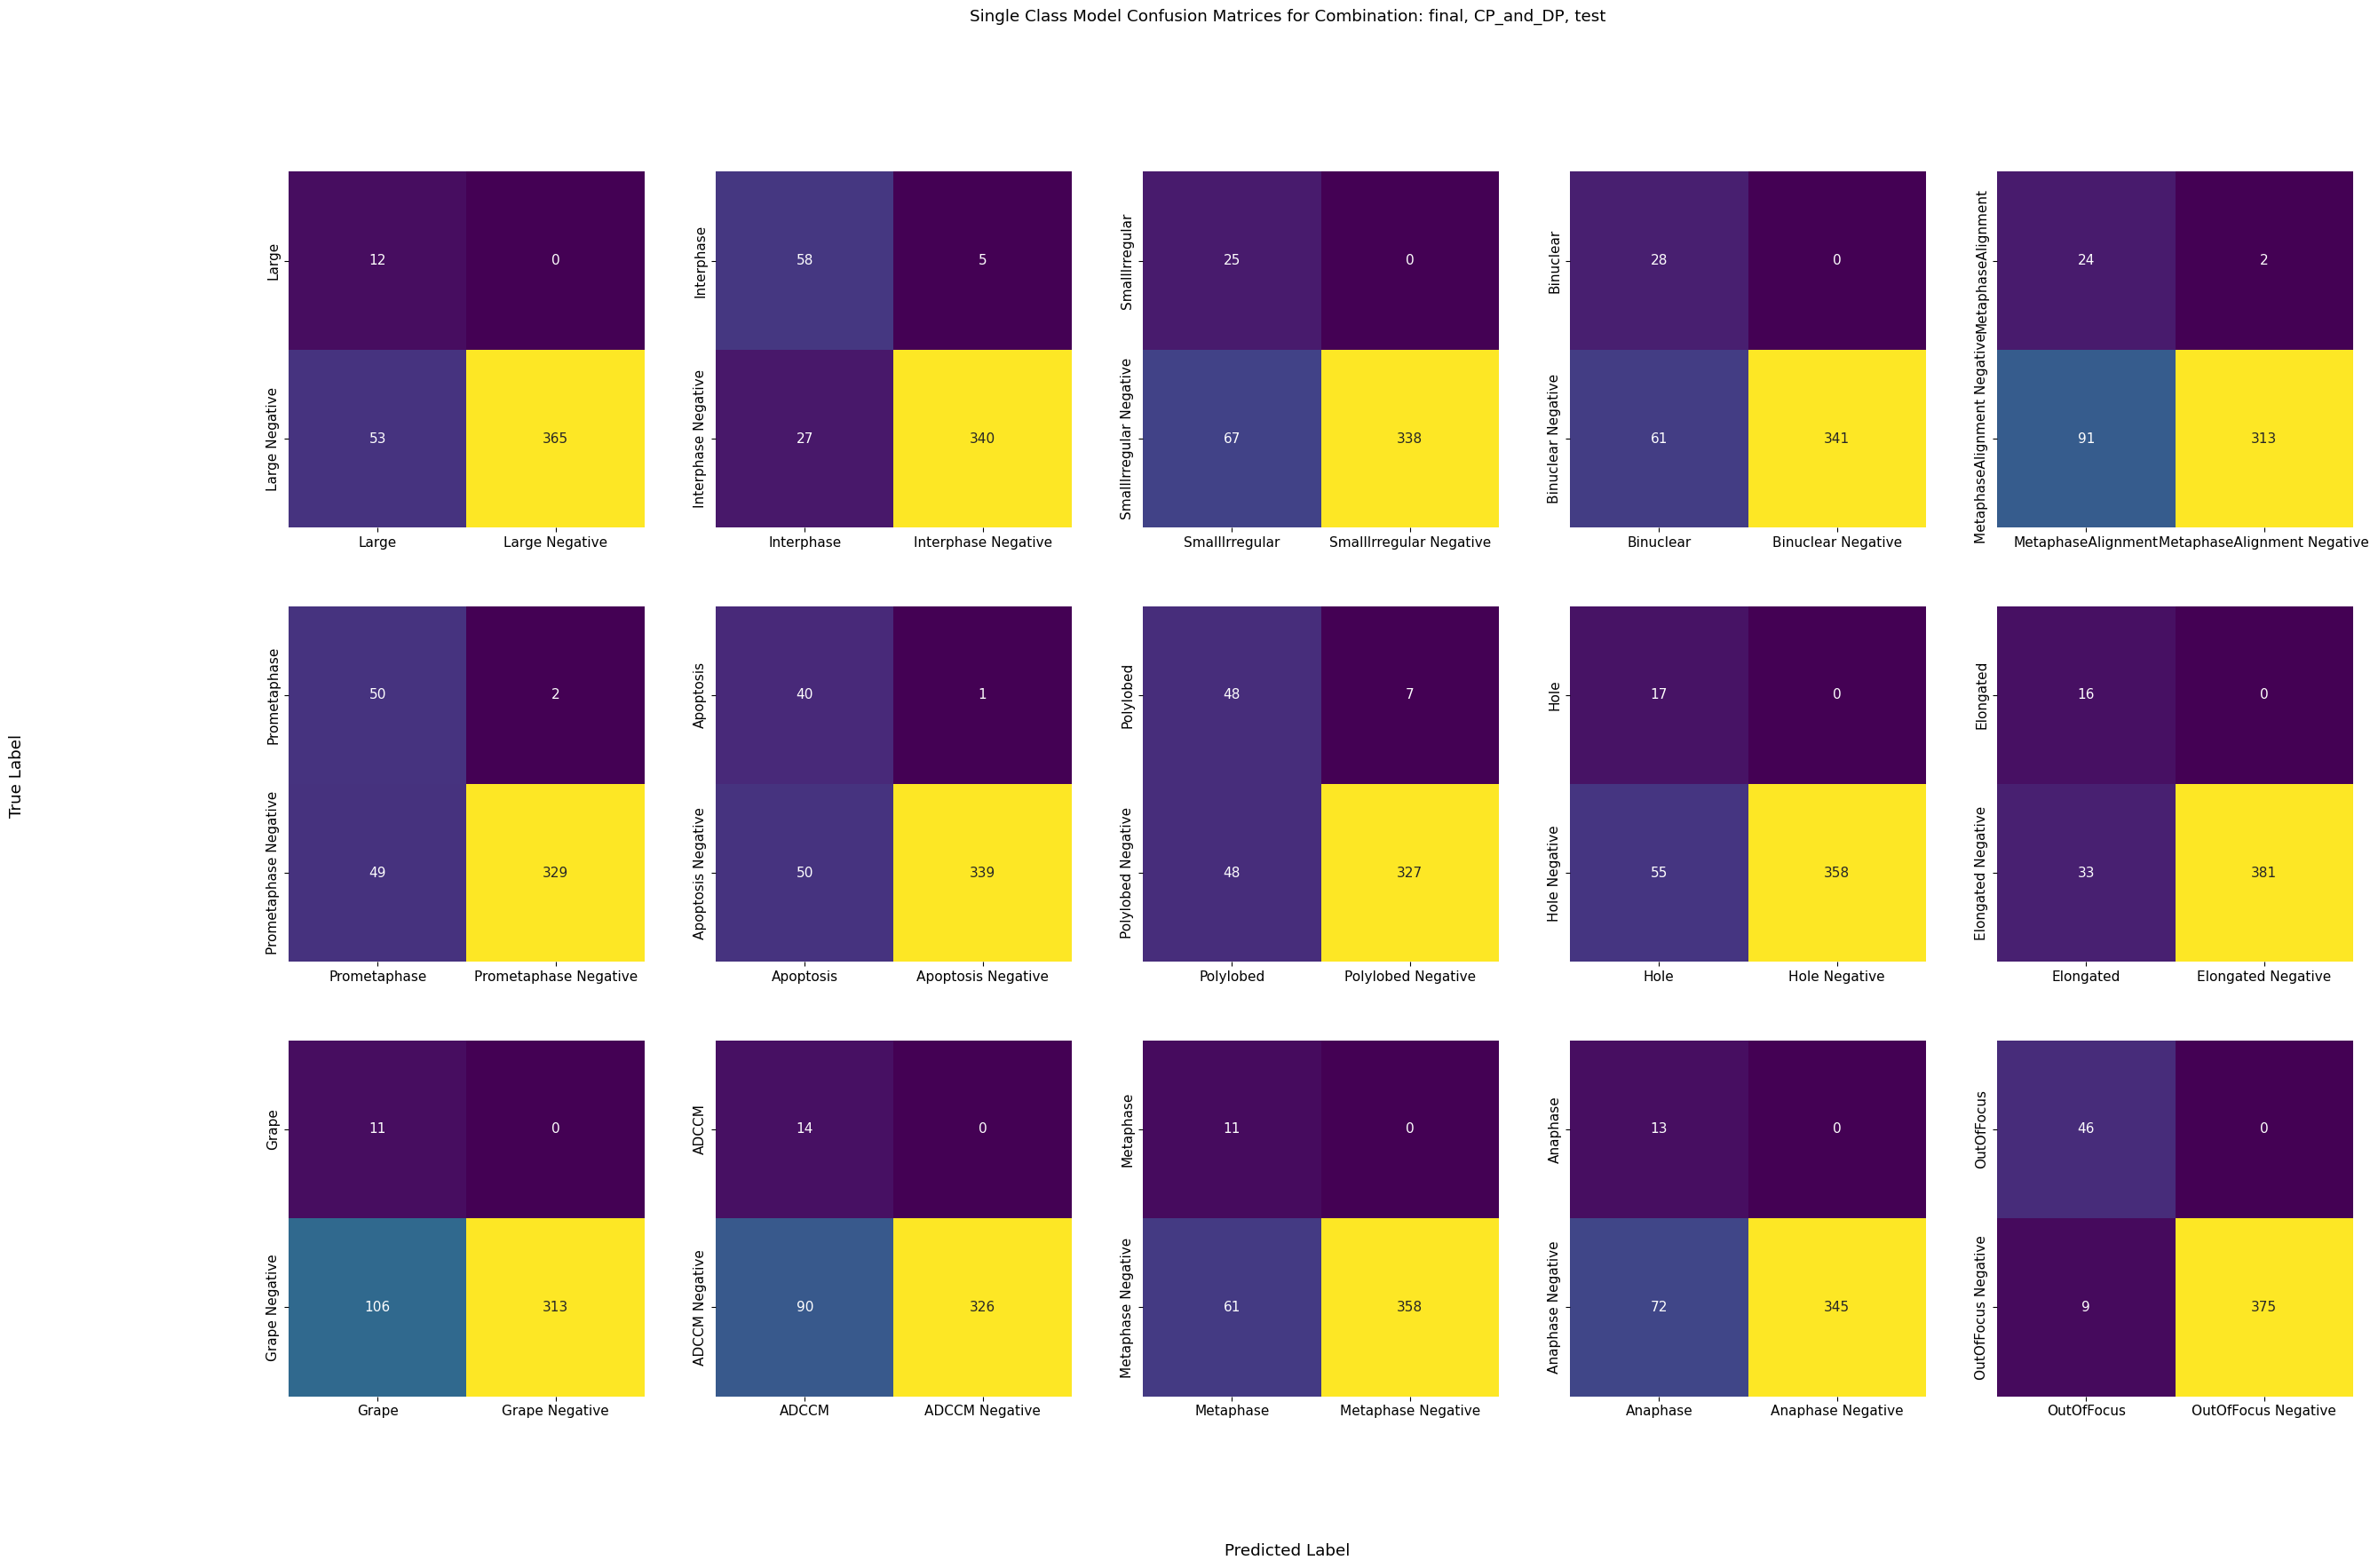

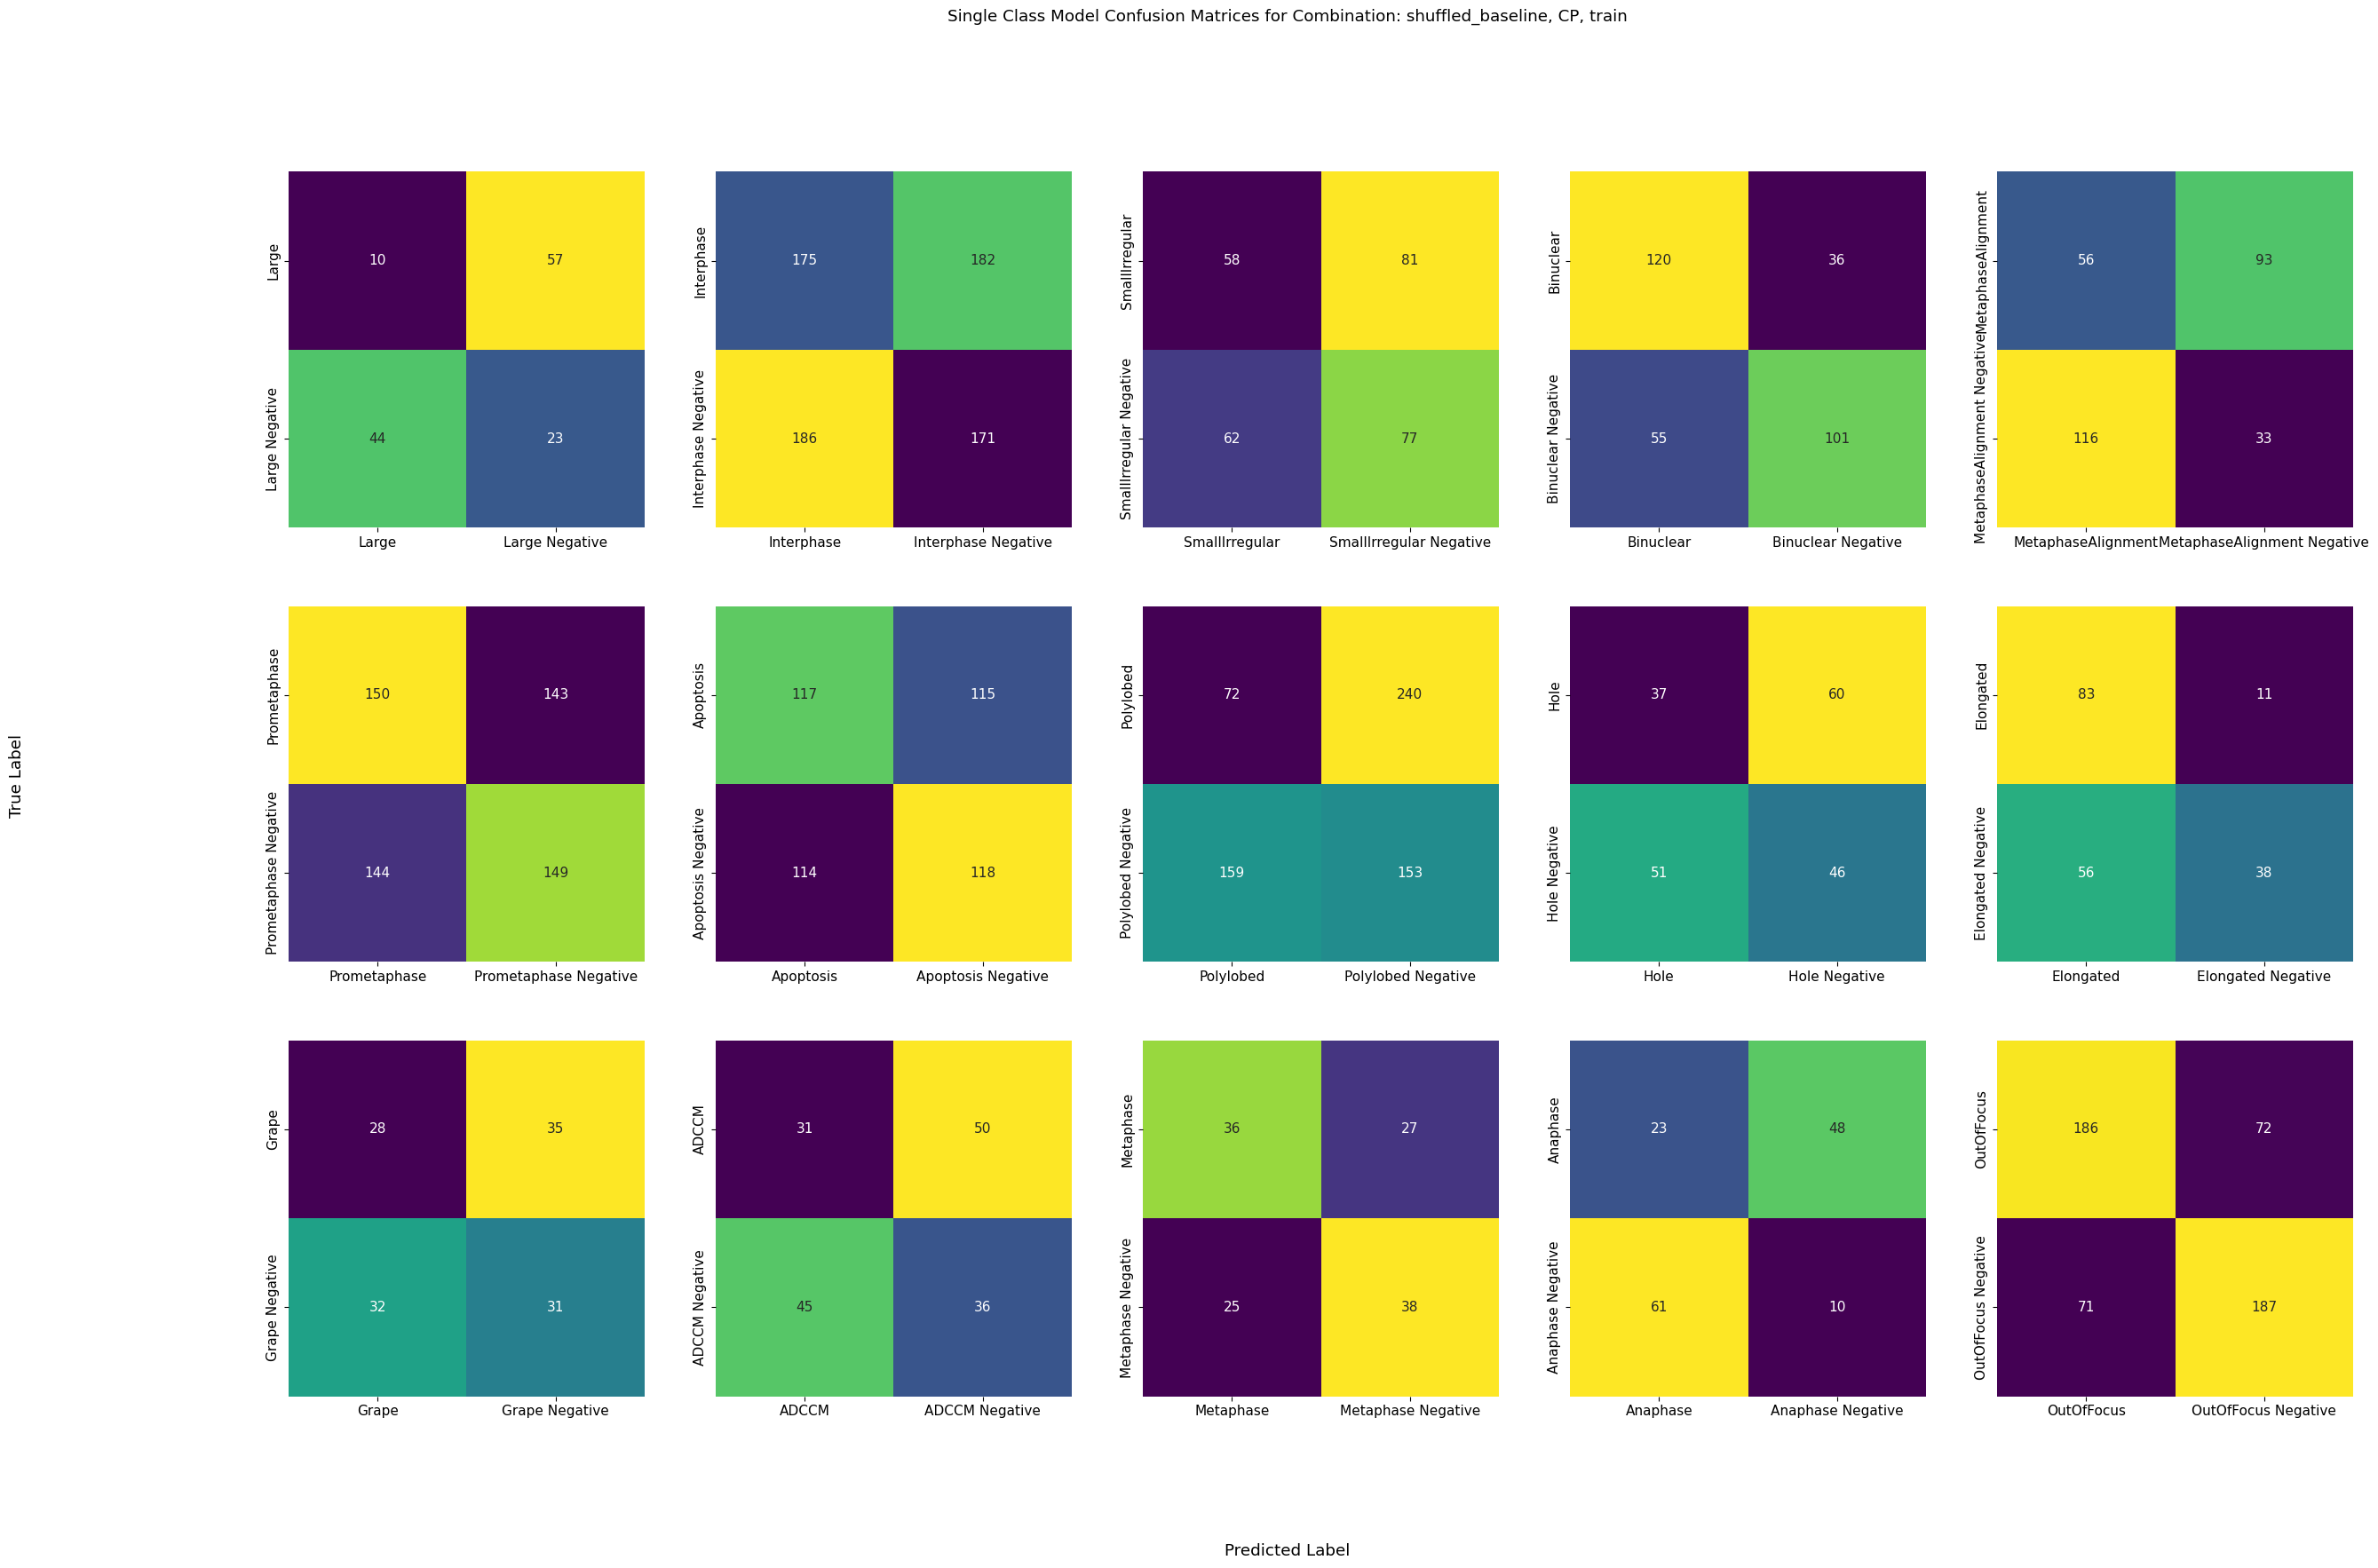

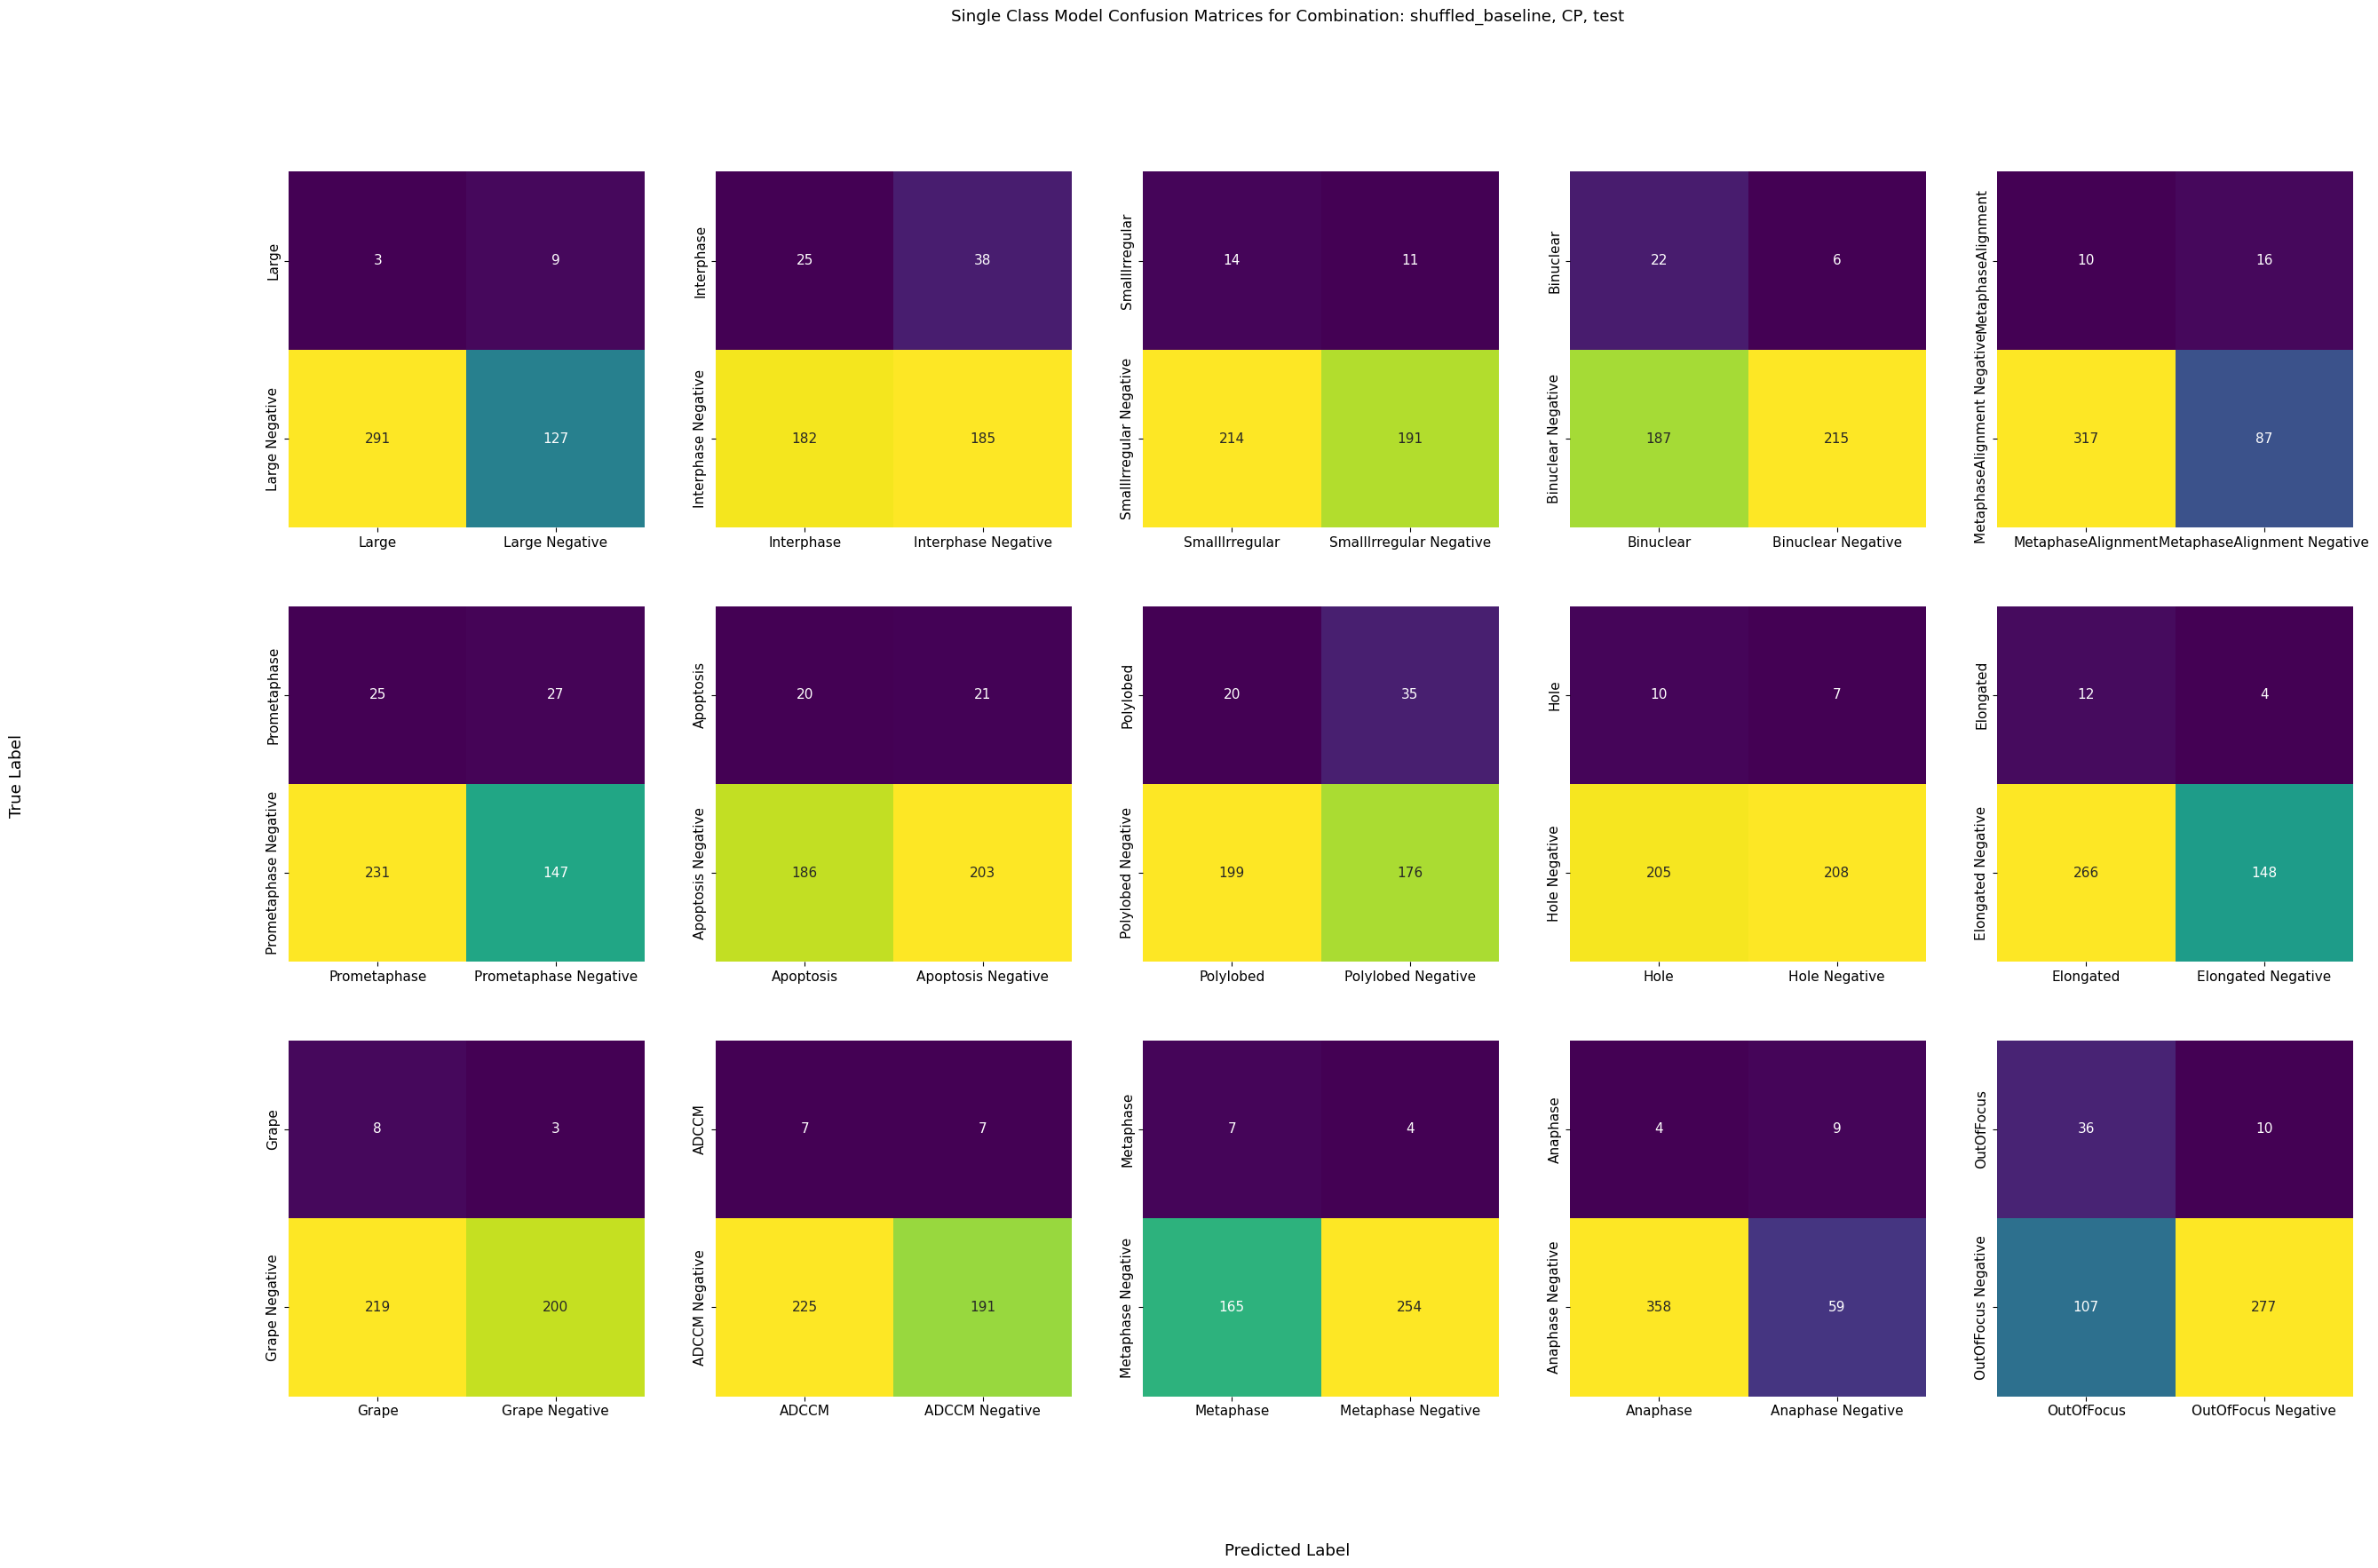

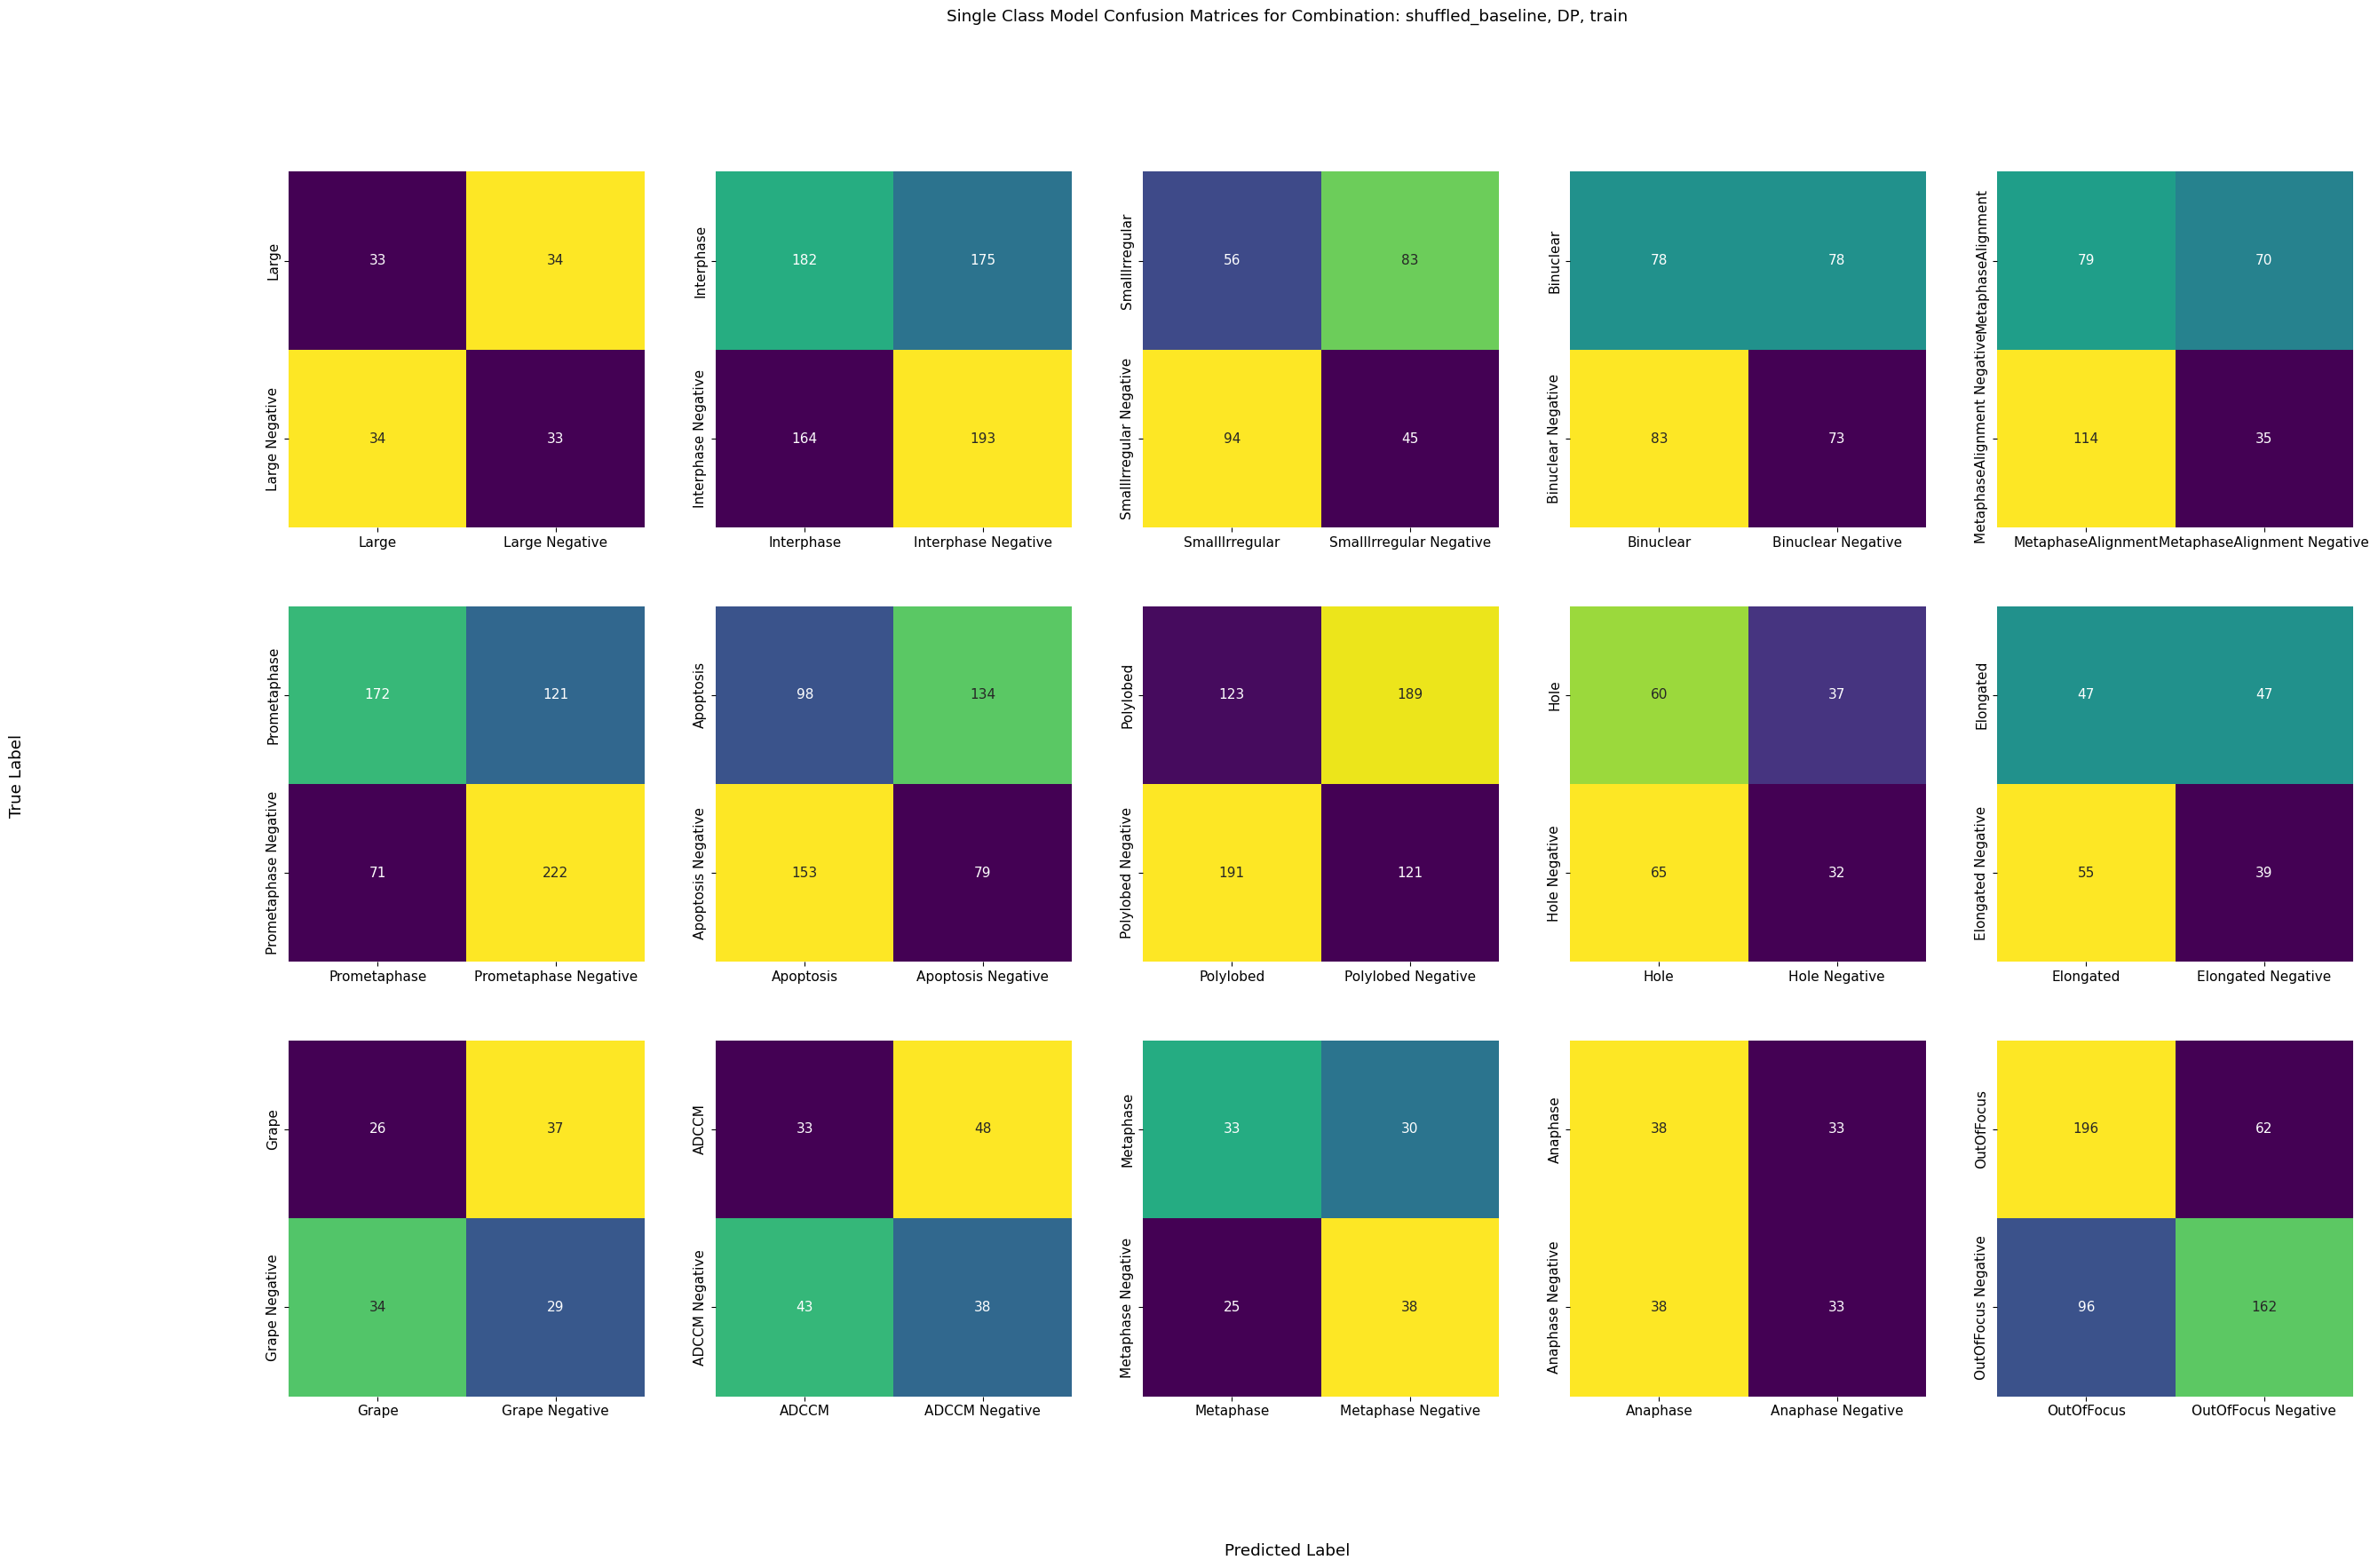

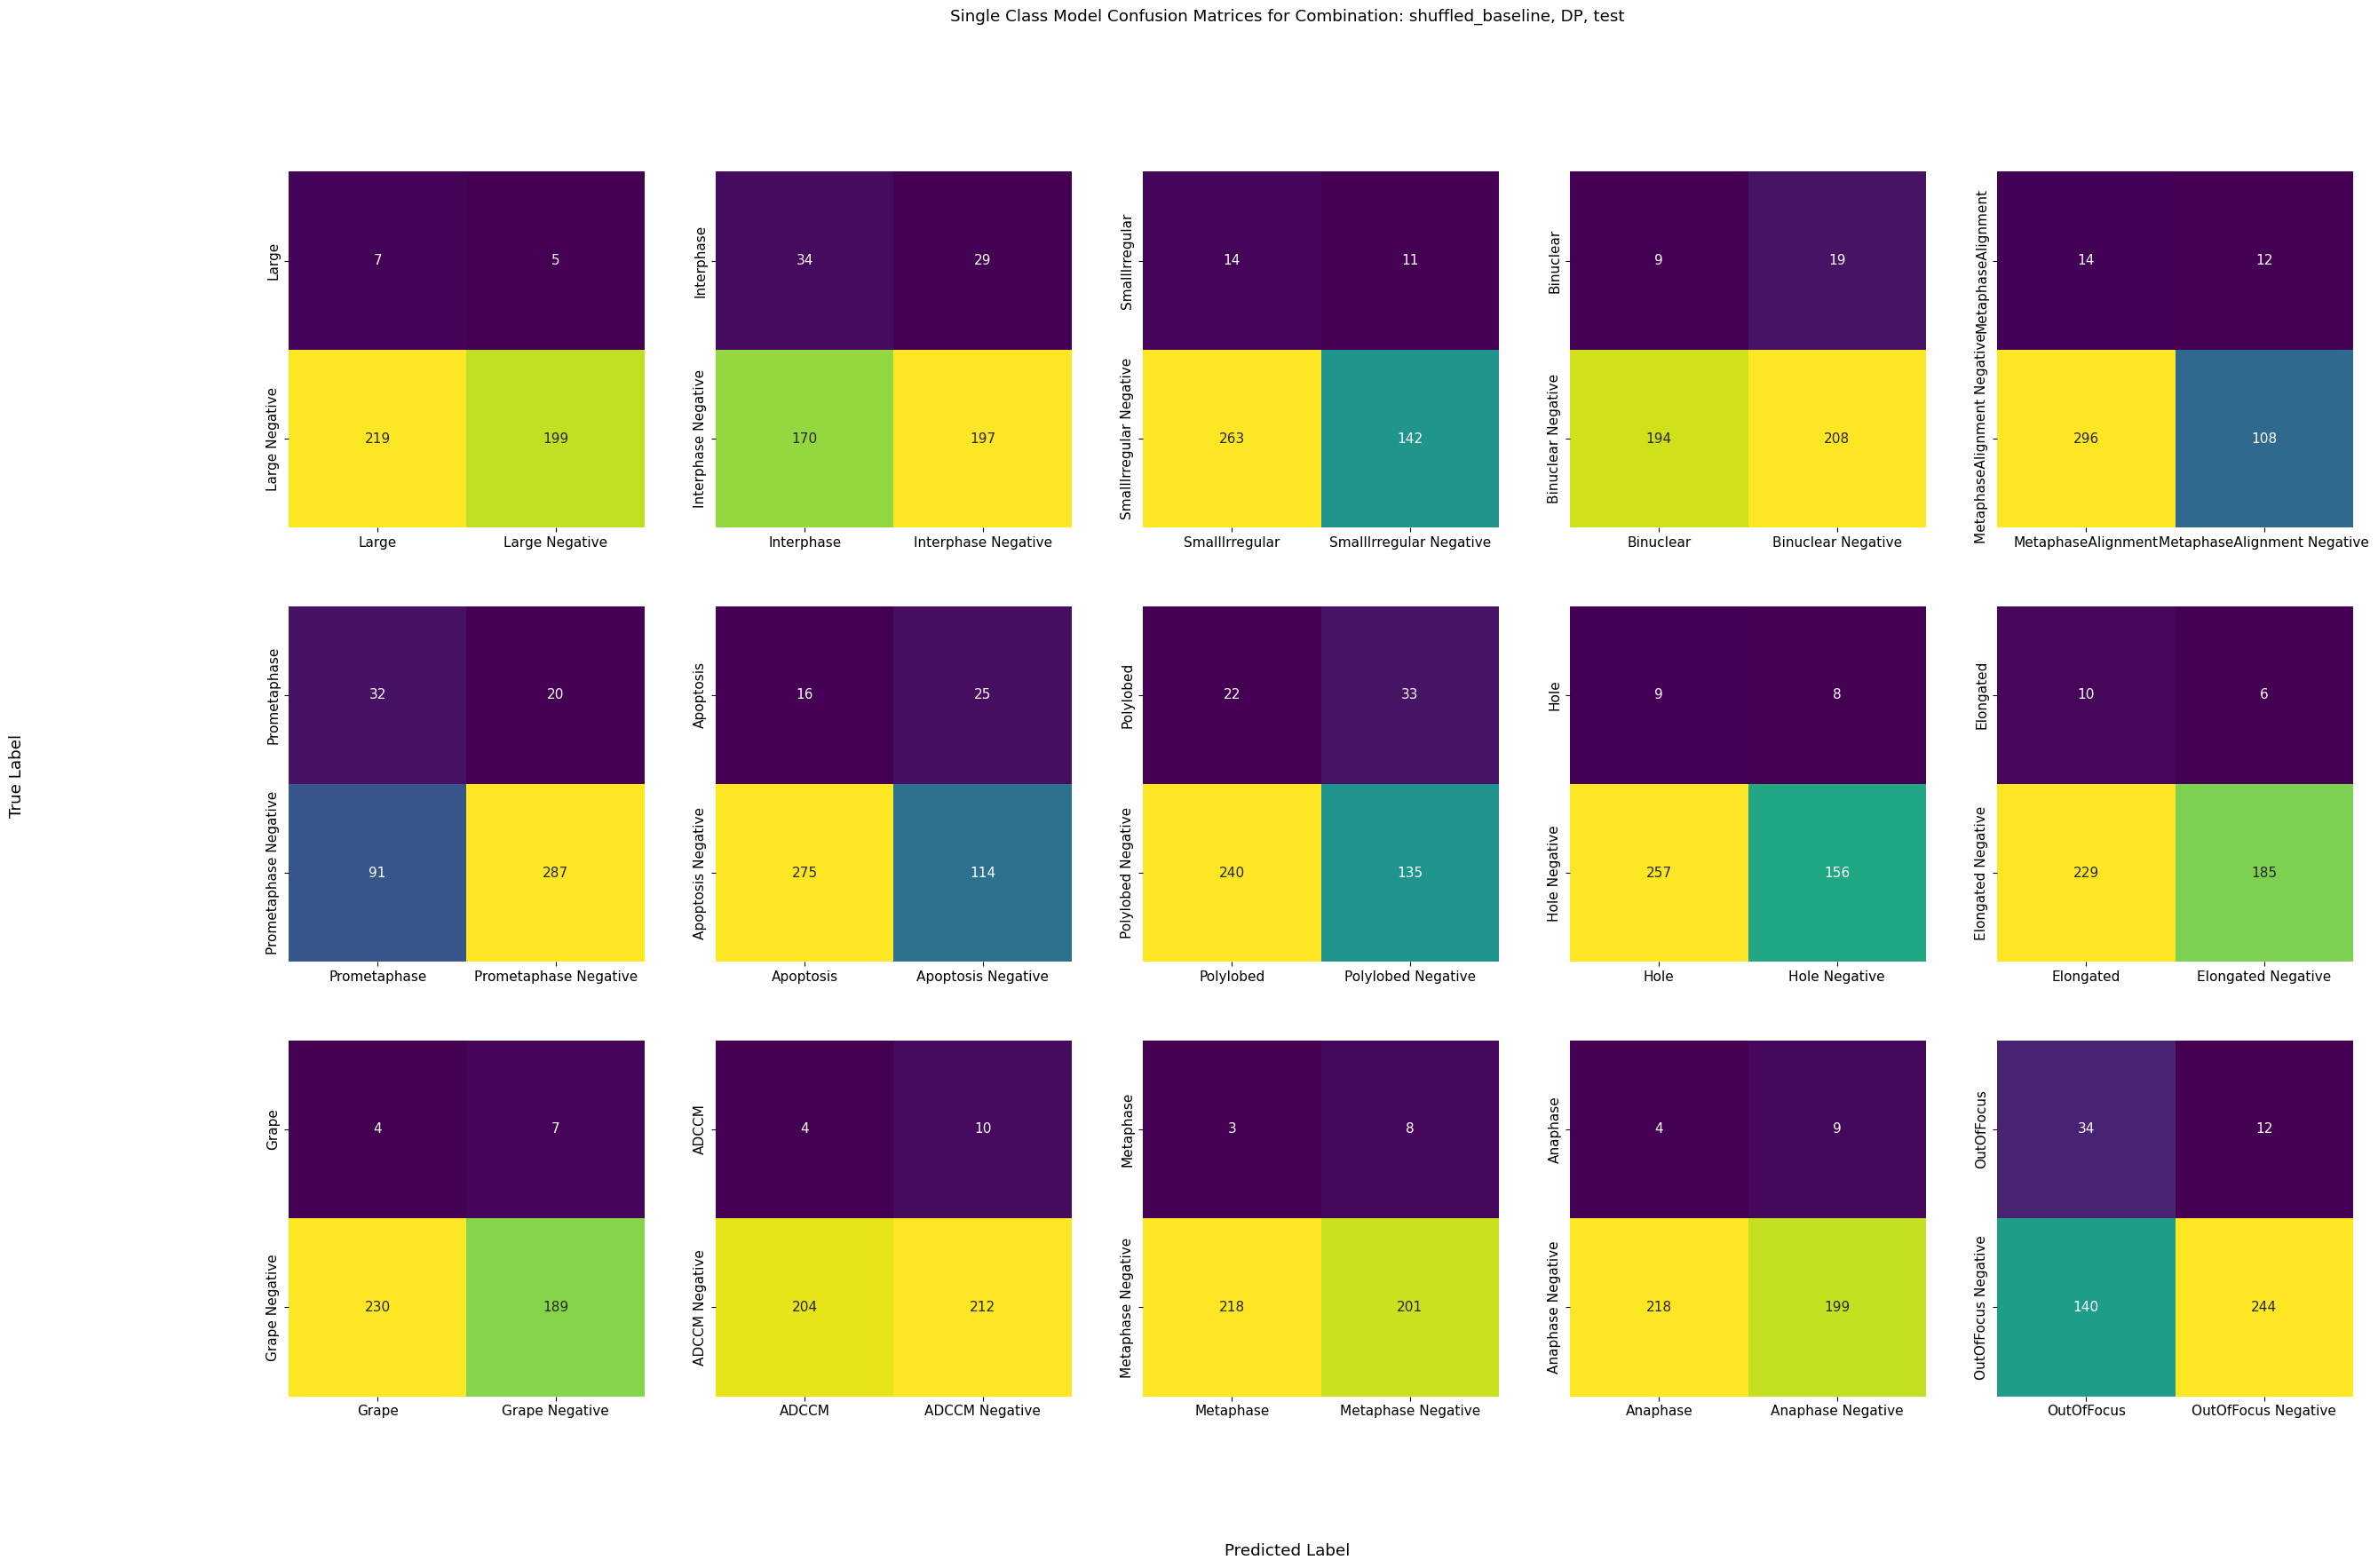

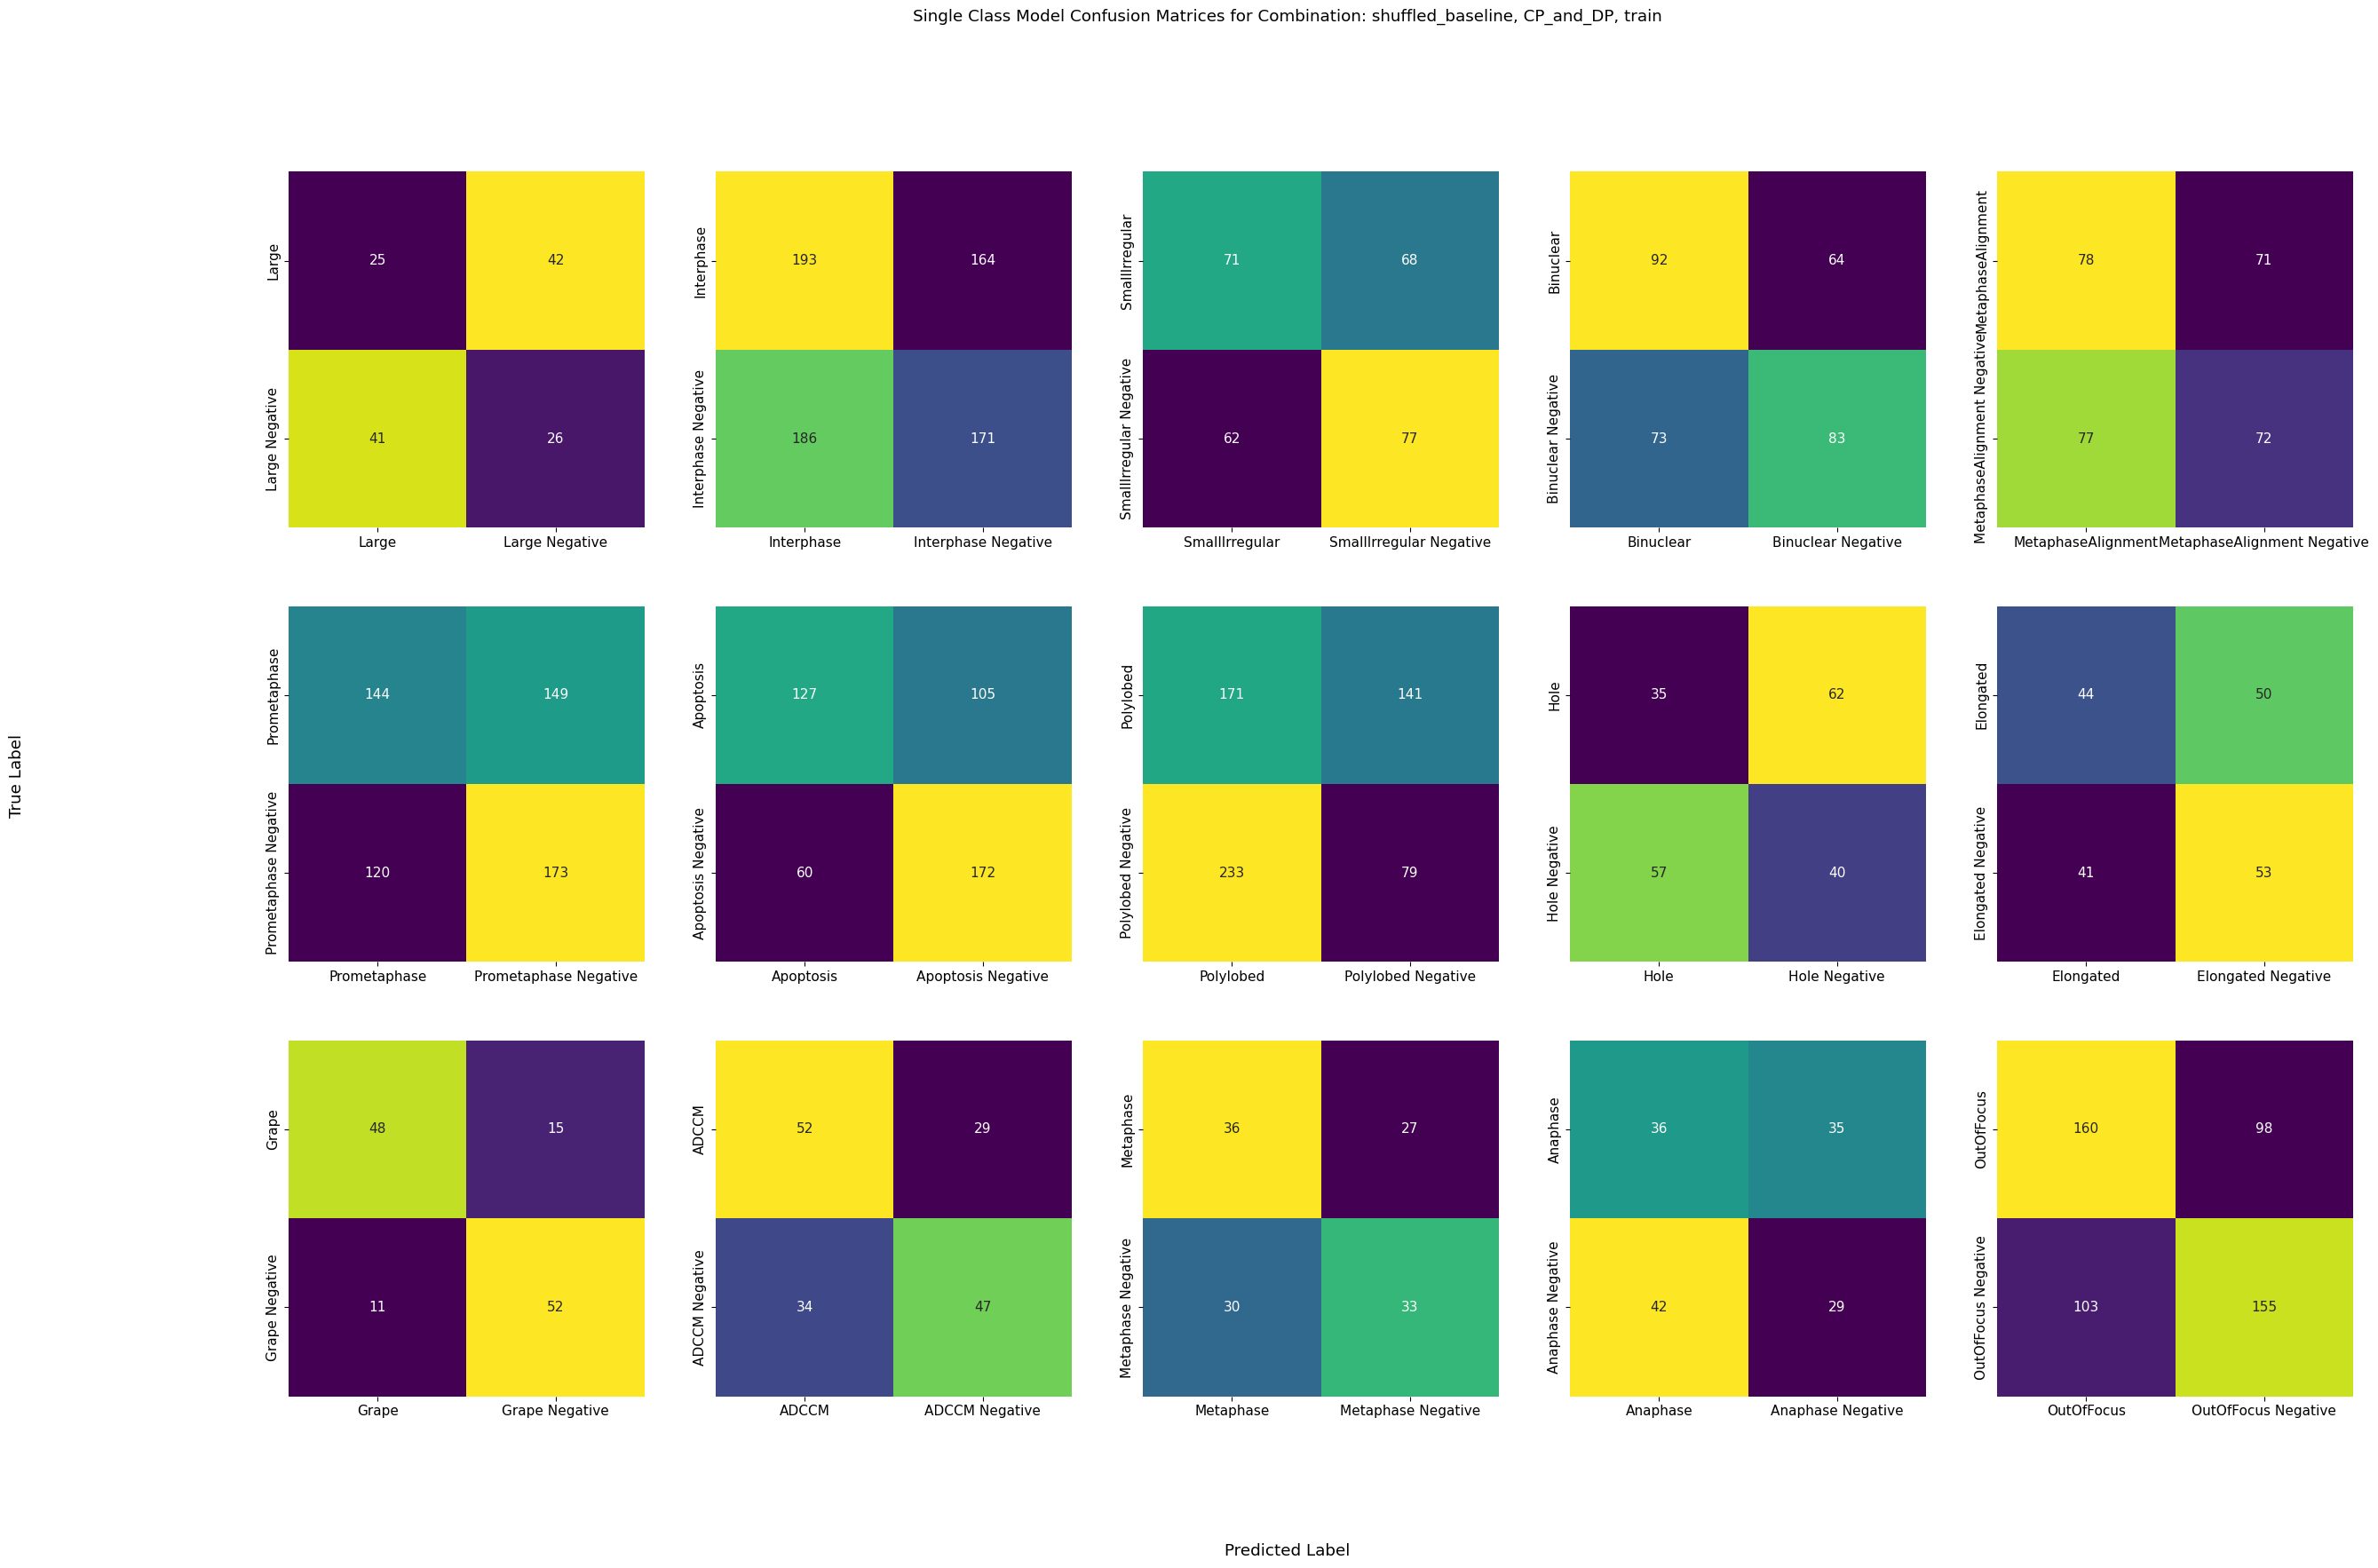

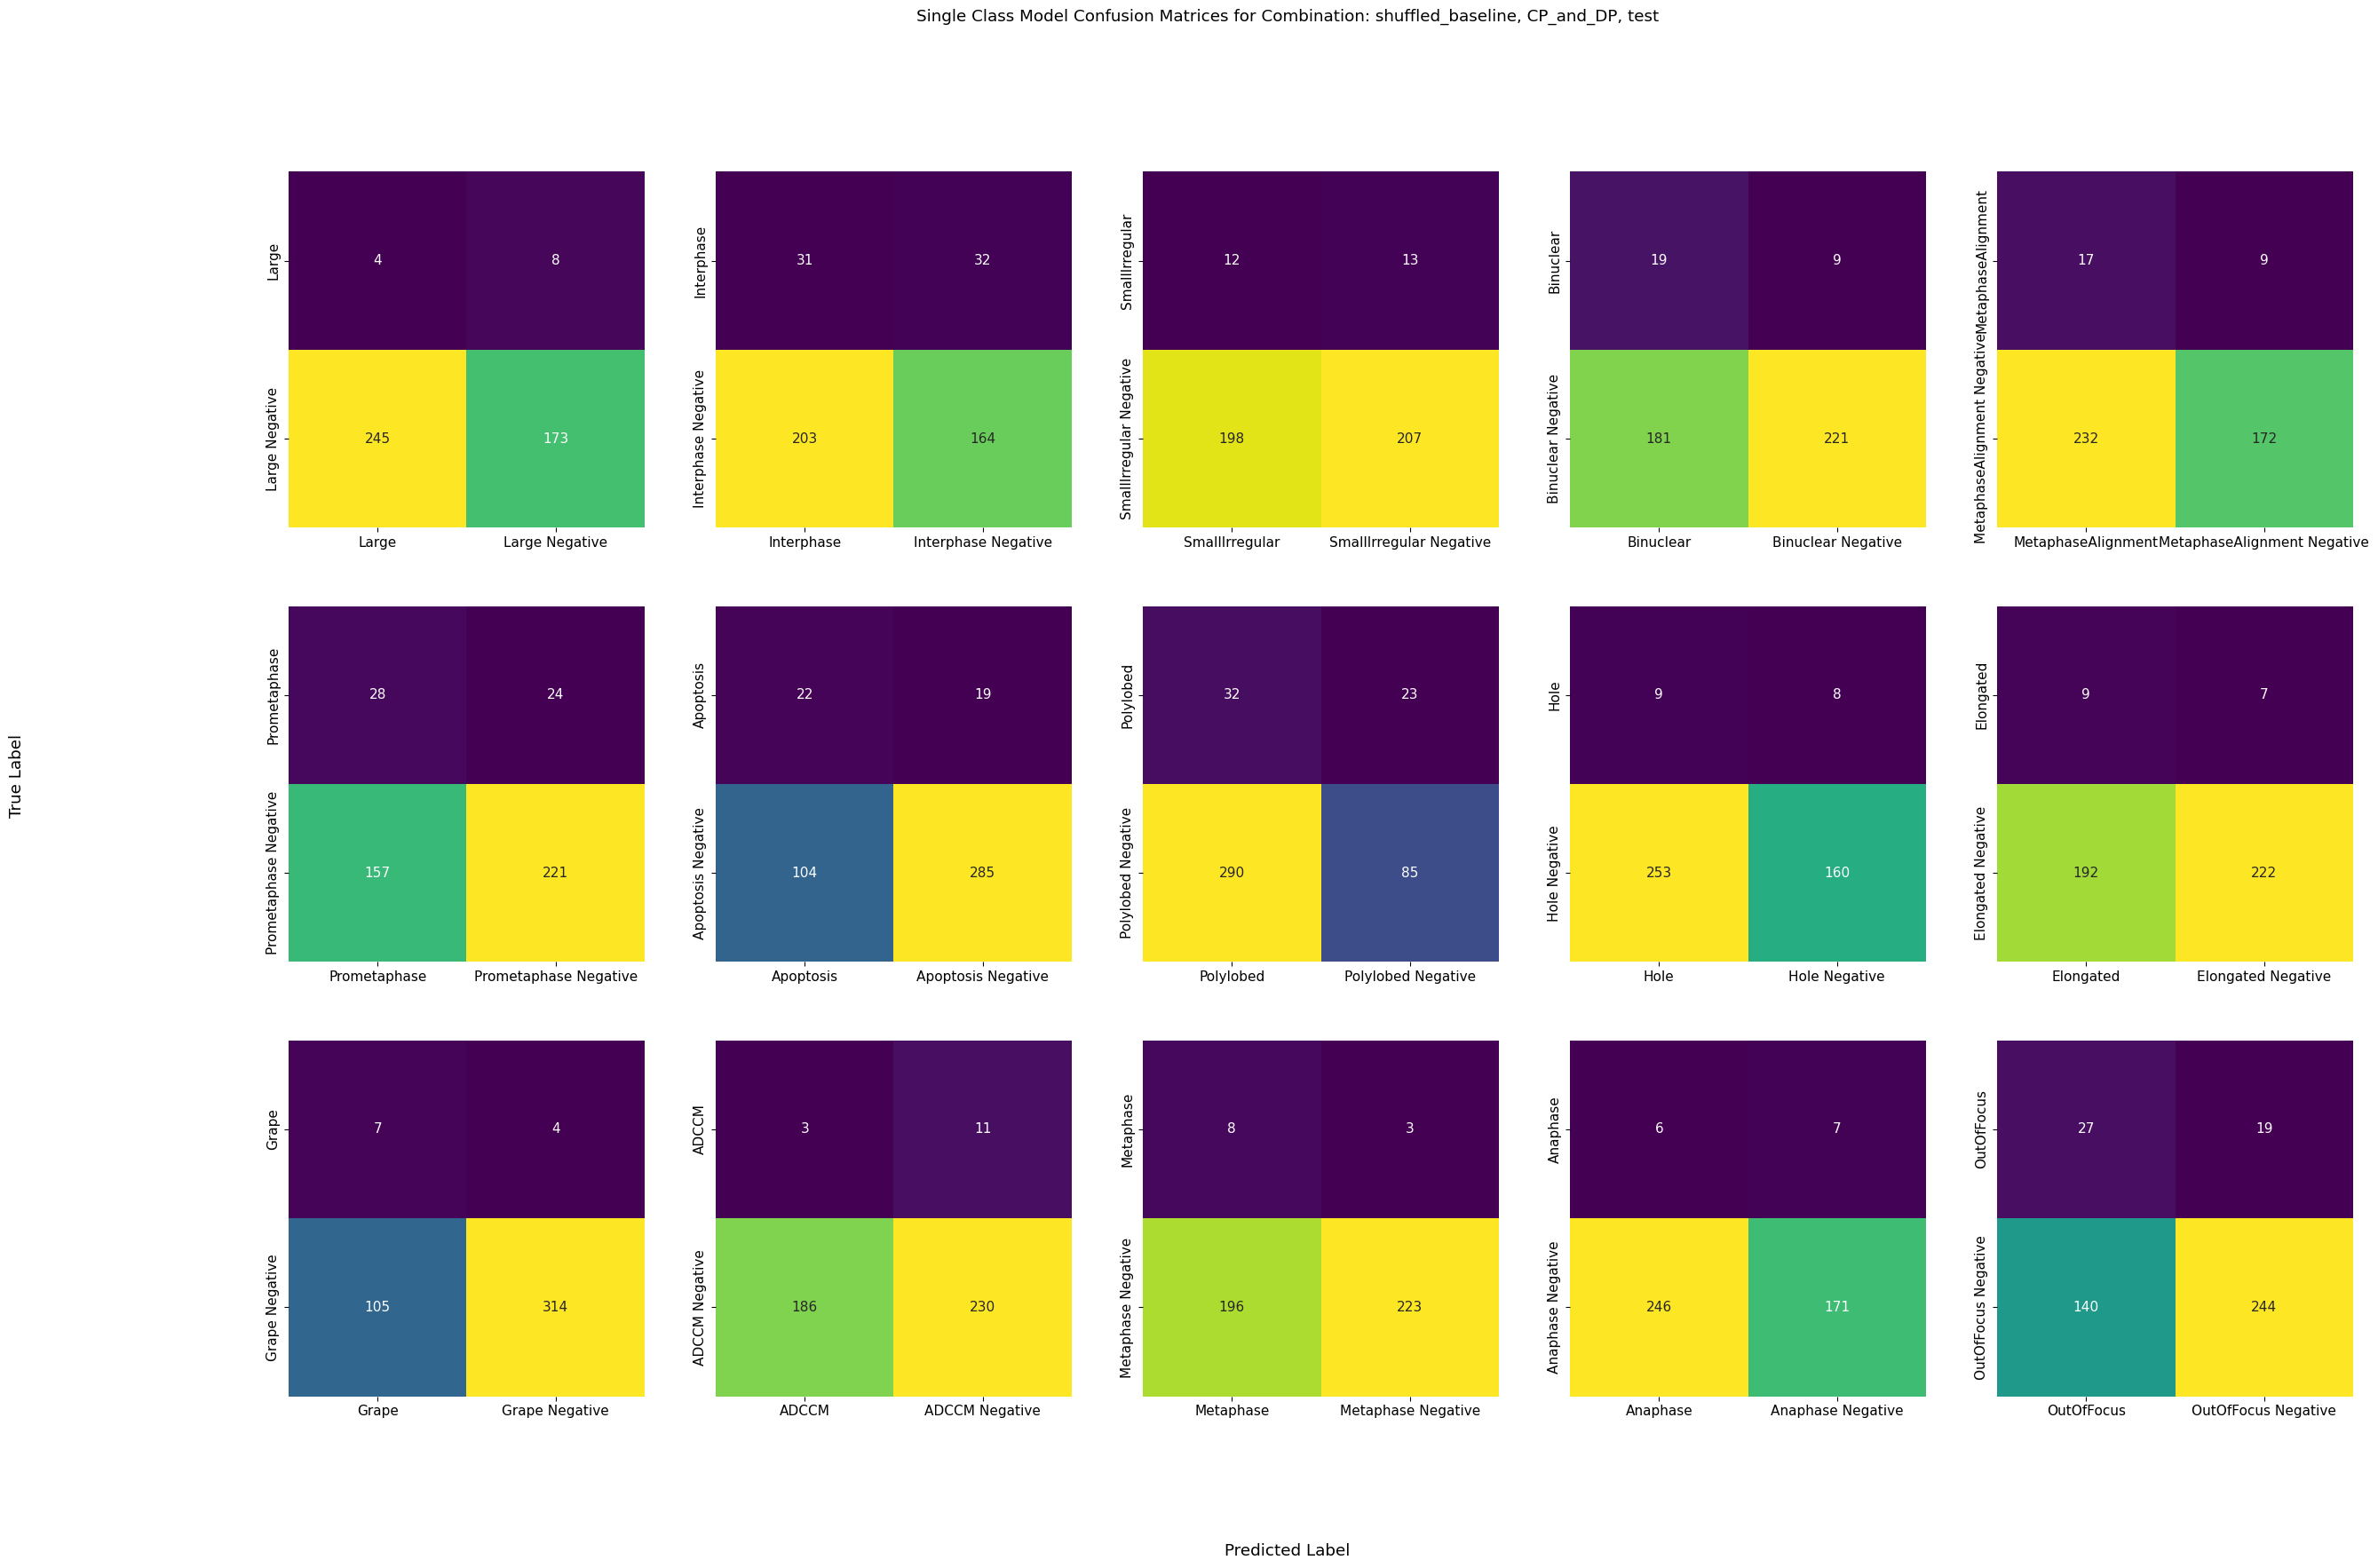

In [5]:

# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_cm_data = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
evaluation_types = ["train", "test"]
phenotypic_classes = features_dataframe["Mitocheck_Phenotypic_Class"].unique()

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type, evaluation_type in itertools.product(
    model_types, feature_types, evaluation_types
):
    # create a figure that has 3x5 subplots for 15 phenotypic classes
    fig, axs = plt.subplots(3, 5)
    fig.set_size_inches(30, 18)
    # variables to keep track of figure subplot coordinates
    ax_x = 0
    ax_y = 0

    for phenotypic_class in phenotypic_classes:
        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)

        # load dataset (train, test, etc)
        single_cell_data = get_dataset(
            features_dataframe, data_split_indexes, evaluation_type
        )
        # rename negative labels and downsample negative labels if we are evaluating on training data
        single_cell_data = get_SCM_model_data(
            single_cell_data, phenotypic_class, evaluation_type
        )

        # make font small for phenotypic class labels
        plt.rcParams.update({"font.size": 11})
        # find confusion matrix for chosen model evaluated on chosen dataset
        cm_data, _ = model_confusion_matrix(
            single_class_model, single_cell_data, feature_type, ax=axs[ax_x, ax_y]
        )

        # add confusion matrix data to compiled dataframe in tidy format
        # use stack to restructure dataframe into tidy long format
        cm_data = cm_data.stack()
        # reset index must be used to make indexes at level 0 and 1 into individual columns
        # these columns correspond to true label and predicted label, and are set as indexes after using stack()
        cm_data = pd.DataFrame(cm_data).reset_index(level=[0, 1])
        cm_data.columns = ["True_Label", "Predicted_Label", "Count"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        cm_data["data_split"] = evaluation_type
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        cm_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        cm_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_cm_data.append(cm_data)

        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1

    # add title and axes labels to figure
    fig.suptitle(
        f"Single Class Model Confusion Matrices for Combination: {model_type}, {feature_type}, {evaluation_type}"
    )
    fig.supxlabel("Predicted Label")
    fig.supylabel("True Label")
    plt.plot()


### Save PR curve data from each evaluation (single class models)


In [6]:
# compile list of tidy data into one dataframe
compiled_cm_data = pd.concat(compiled_cm_data).reset_index(drop=True)

# specify results directory
cm_data_dir = pathlib.Path("evaluations/confusion_matrices/")
cm_data_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_cm_data_save_path = pathlib.Path(f"{cm_data_dir}/compiled_SCM_cm_data.tsv")

# save data as tsv
compiled_cm_data.to_csv(compiled_cm_data_save_path, sep="\t")

# preview tidy data
compiled_cm_data

True_Label      Predicted_Label  Count data_split  shuffled  \
0                  Large                Large     65      train     False   
1                  Large       Large Negative      2      train     False   
2         Large Negative                Large      7      train     False   
3         Large Negative       Large Negative     60      train     False   
4           Prometaphase         Prometaphase    284      train     False   
..                   ...                  ...    ...        ...       ...   
715   Elongated Negative   Elongated Negative    222       test      True   
716           OutOfFocus           OutOfFocus     27       test      True   
717           OutOfFocus  OutOfFocus Negative     19       test      True   
718  OutOfFocus Negative           OutOfFocus    140       test      True   
719  OutOfFocus Negative  OutOfFocus Negative    244       test      True   

    feature_type  
0             CP  
1             CP  
2             CP  
3             CP  
4             CP  
..           ...  
715    CP_and_DP  
716    CP_and_DP  
717    CP_and_DP  
718    CP_and_DP  
719    CP_and_DP  

[720 rows x 6 columns]